<a href="https://colab.research.google.com/github/ai40uw/engr521/blob/pickle/engr521_group1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#initialization - do not run

In [ ]:
# !git clone https://github.com/iikka-v/ML-NDT.git
# !cp -r ML-NDT/data/training /content/drive/MyDrive/engr521_dataset
# !cp -r ML-NDT/data/validation /content/drive/MyDrive/engr521_dataset

Cloning into 'ML-NDT'...
remote: Enumerating objects: 632, done.
remote: Total 632 (delta 0), reused 0 (delta 0), pack-reused 632 (from 1)
Receiving objects: 100% (632/632), 174.01 MiB | 9.60 MiB/s, done.
Resolving deltas: 100% (358/358), done.
Updating files: 100% (809/809), done.


In [ ]:
# Copy training folder to your Google Drive
# !cp -r /content/training /content/drive/MyDrive/2025_hw/engr521/training

In [ ]:
#show folder size for the engr521_dataset folder
# !du -sh /content/drive/MyDrive/engr521_dataset

2.5G	/content/drive/MyDrive/engr521_dataset


#Start

In [ ]:
#mount drive - run it one time per a session
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Exporting .jsons file from the dataset

In [ ]:
import pandas as pd
import json
import re

# Read the content of the file
with open('/content/drive/MyDrive/engr521_dataset/validation/F68B8BC9-C4D5-4848-923E-A68176F821D2.jsons', 'r') as f:
    data = f.read()

# Prepare to decode multiple JSON objects from the string
decoder = json.JSONDecoder()
pos = 0
flaws_list = []

while pos < len(data):
    try:
        obj, next_pos = decoder.raw_decode(data, pos)
        pos = next_pos
        if "flaws" in obj:
            flaws_list.extend(obj["flaws"])
    except json.JSONDecodeError as e:
        print(f"Skipping invalid JSON at position {pos}: {e}")
        break  # or use pos += 1 to continue trying

# Convert to DataFrame
df = pd.DataFrame(flaws_list)
print(df.head())

                               location size        location_max  \
0   3654.237885462555-3899.339207048458  0.0  2198.7463370141086   
1                             4148-4317  1.6                4317   
2                             3387-3739  8.6                3739   
3  3999.6079295154186-4244.709251101322  0.0   2393.492441149644   
4  1604.2995594713657-2038.797356828194  4.0  1149.6302276388055   

        noise_flawsize              factor max_amplitude original_location  \
0                  0.0  0.8244211456795272          4050           558-580   
1  0.21340411413404115  0.6861373873395233          6028           763-790   
2  0.33668739882423104  0.7151297856390313         23474           642-698   
3                  0.0  0.5349937875370946          4050           527-549   
4    0.503911518748314  0.9734535488471048          7414           725-764   

  equivalent_flawsize noise_threshold        location_min  
0                 0.0             973  2060.5394244017934  
1 

In [ ]:
!pip install openpyxl  # Install openpyxl for Excel writing
import pandas as pd

# Assuming 'df' is your DataFrame
df.to_excel('flaws_data.xlsx', index=False, engine='openpyxl')

# Download the file (optional)
from google.colab import files
files.download('flaws_data.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#plotting 5 images from the dataser

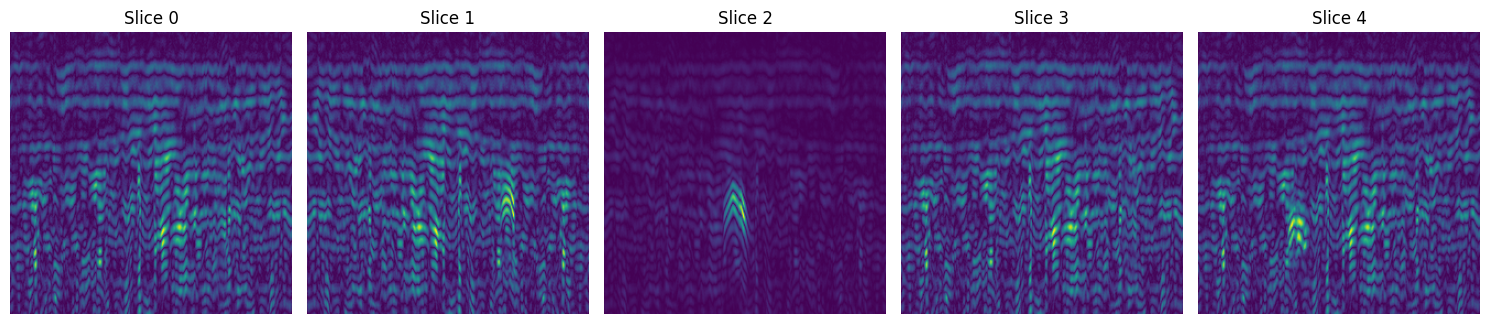

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Path to a sample .bins file
file_path = "/content/drive/MyDrive/engr521_dataset/validation/F68B8BC9-C4D5-4848-923E-A68176F821D2.bins"

# Load raw data (uint16 format), then reshape to 3D volume
data = np.fromfile(file_path, dtype=np.uint16)
data = data.reshape((100, 256, 256))  # Shape: [depth, height, width]

# Normalize data for visualization
data = data.astype(np.float32)
data -= data.mean()
data /= data.std() + 1e-5

# Plot a few slices (e.g., along the first axis)
plt.figure(figsize=(15, 5))
for i in range(5):  # Plot first 5 slices
    plt.subplot(1, 5, i + 1)
    plt.imshow(data[i], cmap='viridis')
    plt.title(f"Slice {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#saving a sample .bins batch of 100 images

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Load your DataFrame (assuming it's already loaded as df)
# Example: df = pd.read_csv("your_csv.csv")  <-- if needed

# Path to a sample .bins file
file_path = "/content/drive/MyDrive/engr521_dataset/validation/F68B8BC9-C4D5-4848-923E-A68176F821D2.bins"

# Output image folder
output_folder = "/content/drive/MyDrive/engr521_dataset/Images"
os.makedirs(output_folder, exist_ok=True)

# Load raw data (uint16 format), then reshape to 3D volume
data = np.fromfile(file_path, dtype=np.uint16)
data = data.reshape((100, 256, 256))  # Shape: [depth, height, width]

# Normalize data for visualization
data = data.astype(np.float32)
data -= data.mean()
data /= data.std() + 1e-5

# Save first 5 slices as PNGs with custom names
for i in range(100):
    if i >= len(df):
        print(f"Skipping slice {i}: no corresponding row in DataFrame.")
        continue

    size_value = df.iloc[i]["size"]
    filename = f"{i:04d}_{size_value}.png"
    filepath = os.path.join(output_folder, filename)

    plt.imsave(filepath, data[i], cmap='viridis')

print("Images saved successfully.")


Images saved successfully.


#Convert to Pickles

(200, 256, 256)
(200, 2)


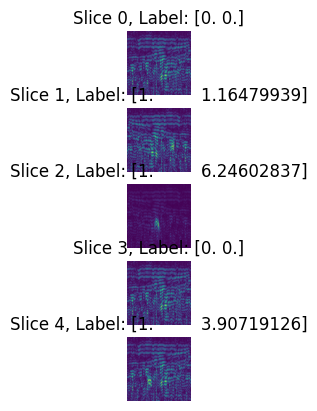

In [19]:
#use pickles library to collect images from .bins file and .labels file
import pickle
import numpy as np
import os

# Path to .bins file and .labels file
path = "/content/drive/MyDrive/engr521_dataset/validation/"
# iterate over directory and create a pickle file

all_data = []  # List to store data from all .bins files
all_labels = [] # List to store labels from all .labels files

for filename in os.listdir(path):
  #read images from all .bins files. There are 100 images 256x256 in each bins file

  if filename.endswith(".bins"):
    # Load raw data (uint16 format), then reshape to 3D volume
    data = np.fromfile(path+filename, dtype=np.uint16)
    data = data.reshape((100, 256, 256))  # Shape: [depth, height, width]
    all_data.append(data)  # Append data to the list

  #add columns from .labels file to a csv or dataframe
  elif filename.endswith(".labels"):
    labels = np.loadtxt(path+filename)
    all_labels.append(labels)  # Append labels to the list

# Concatenate along the first axis (depth) to maintain [depth, height, width]
all_data = np.concatenate(all_data, axis=0)

# Concatenate labels to form a matrix (assuming labels are 1D arrays)
all_labels = np.vstack(all_labels)  # Use vstack for vertical stacking

#create a pickle .pkl file with the above images and labels
with open(path+"validation.pkl", "wb") as f:
  pickle.dump((all_data, all_labels), f)
f.close()

#lets see what is in .pkl file
with open(path+"validation.pkl", "rb") as f:
  data, labels = pickle.load(f)
print(data.shape)
print(labels.shape)

#plot first 5 images along with labels data from pickle
import matplotlib.pyplot as plt
for i in range(5):
  plt.subplot(5, 1, i + 1)
  plt.imshow(data[i], cmap='viridis')
  plt.title(f"Slice {i}, Label: {labels[i]}")
  plt.axis('off')
plt.show()

#Intitial training code with slight modifications

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 256, 96)    │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 36, 256, 64)    │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 18, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 32, 48)     │        27,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 32, 32)     │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RNN (Dense)                     │ (None, 14)             │        21,518 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,405 (466.43 KB)

 Trainable params: 119,405 (466.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - acc: 0.6103 - loss: 0.6190
Epoch 1: val_loss improved from inf to 0.51687, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


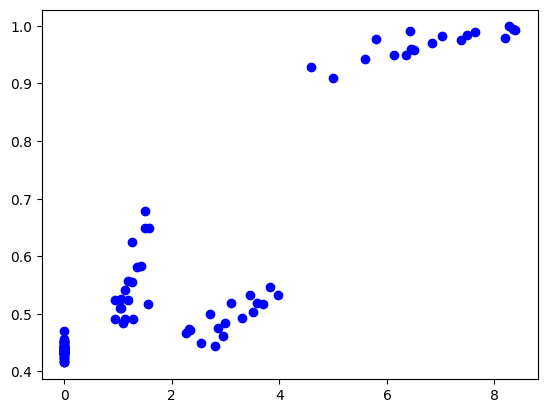

60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - acc: 0.6111 - loss: 0.6182 - val_acc: 0.8800 - val_loss: 0.5169
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - acc: 0.7874 - loss: 0.4809
Epoch 2: val_loss improved from 0.51687 to 0.44008, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


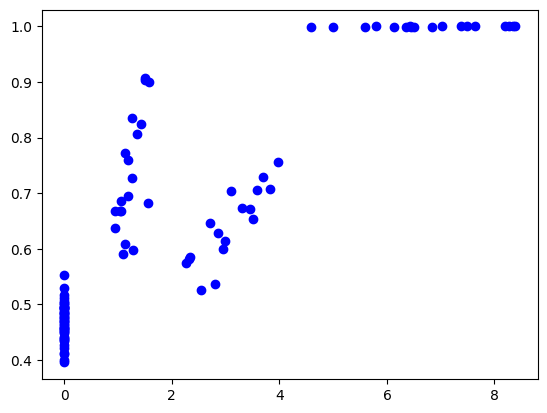

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - acc: 0.7878 - loss: 0.4807 - val_acc: 0.8900 - val_loss: 0.4401
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - acc: 0.8613 - loss: 0.4007
Epoch 3: val_loss improved from 0.44008 to 0.28425, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


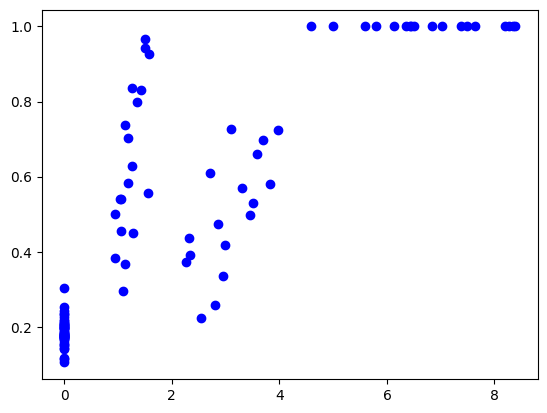

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - acc: 0.8614 - loss: 0.4002 - val_acc: 0.8800 - val_loss: 0.2842
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - acc: 0.8920 - loss: 0.3169
Epoch 4: val_loss improved from 0.28425 to 0.19493, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


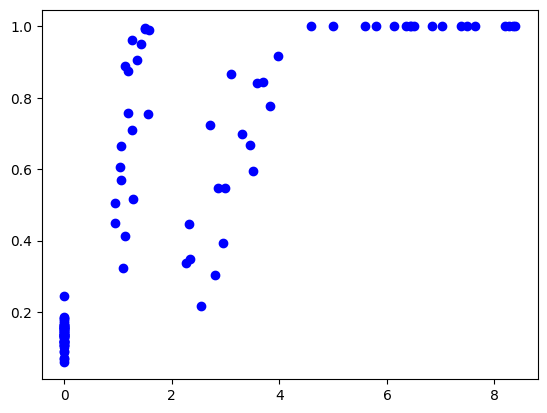

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - acc: 0.8921 - loss: 0.3166 - val_acc: 0.9400 - val_loss: 0.1949
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - acc: 0.9124 - loss: 0.2532
Epoch 5: val_loss did not improve from 0.19493
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


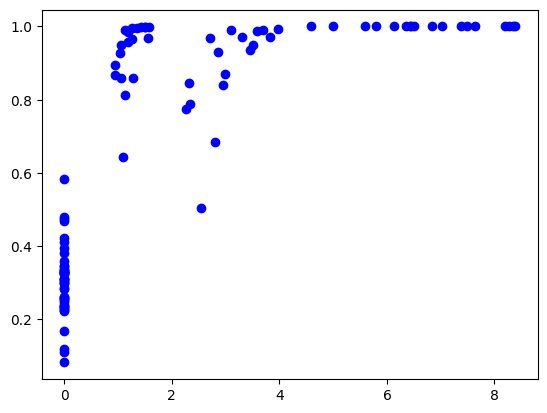

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - acc: 0.9125 - loss: 0.2530 - val_acc: 0.9400 - val_loss: 0.2198
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9182 - loss: 0.2289
Epoch 6: val_loss improved from 0.19493 to 0.11211, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


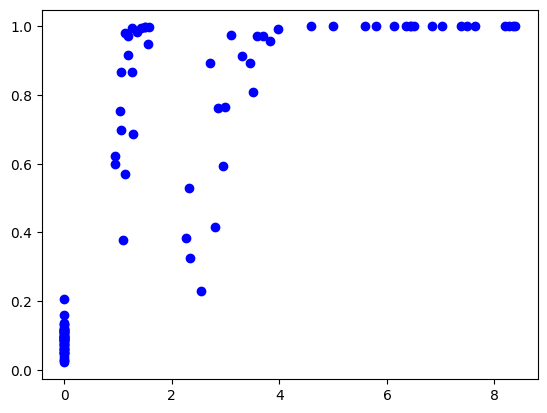

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9183 - loss: 0.2287 - val_acc: 0.9800 - val_loss: 0.1121
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - acc: 0.9304 - loss: 0.2015
Epoch 7: val_loss did not improve from 0.11211
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


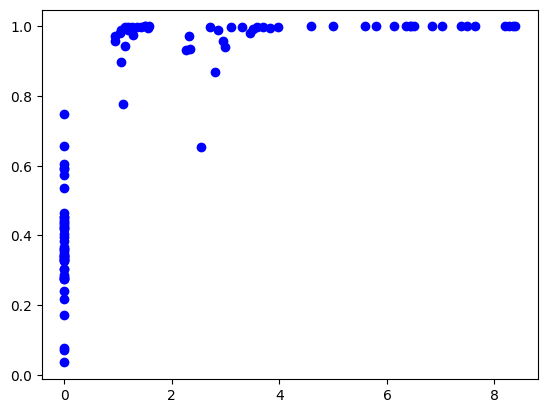

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - acc: 0.9304 - loss: 0.2014 - val_acc: 0.8900 - val_loss: 0.2765
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9346 - loss: 0.1817
Epoch 8: val_loss did not improve from 0.11211
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


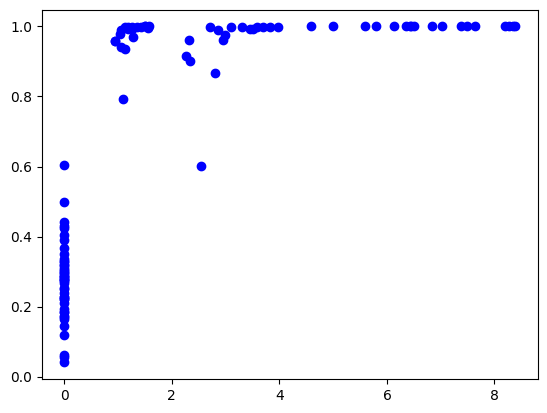

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9346 - loss: 0.1817 - val_acc: 0.9400 - val_loss: 0.1844
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - acc: 0.9424 - loss: 0.1662
Epoch 9: val_loss improved from 0.11211 to 0.06630, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


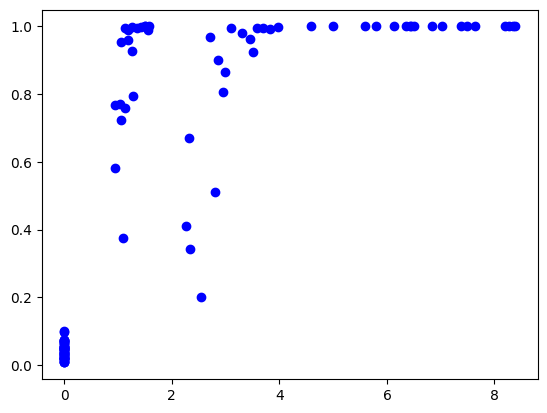

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - acc: 0.9424 - loss: 0.1662 - val_acc: 0.9800 - val_loss: 0.0663
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9460 - loss: 0.1516
Epoch 10: val_loss improved from 0.06630 to 0.05789, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


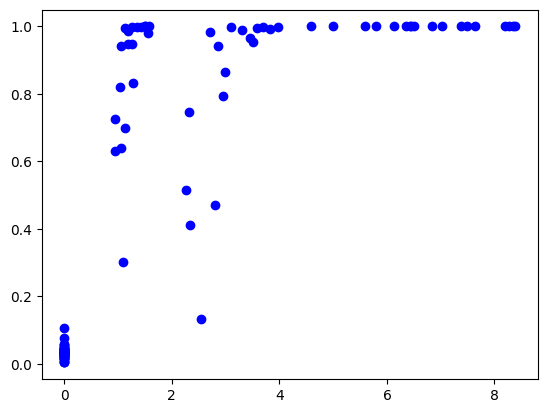

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9460 - loss: 0.1516 - val_acc: 0.9900 - val_loss: 0.0579
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - acc: 0.9502 - loss: 0.1430
Epoch 11: val_loss did not improve from 0.05789
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


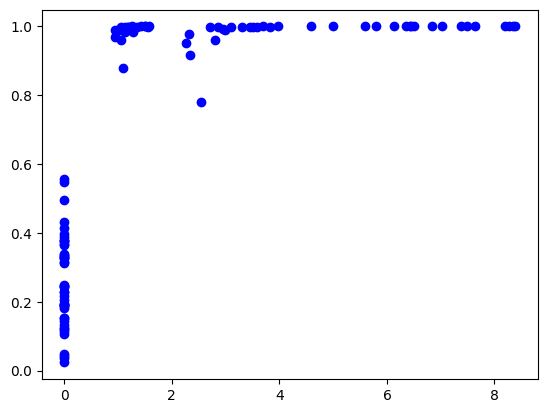

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - acc: 0.9502 - loss: 0.1430 - val_acc: 0.9200 - val_loss: 0.1794
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - acc: 0.9545 - loss: 0.1406
Epoch 12: val_loss improved from 0.05789 to 0.04675, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


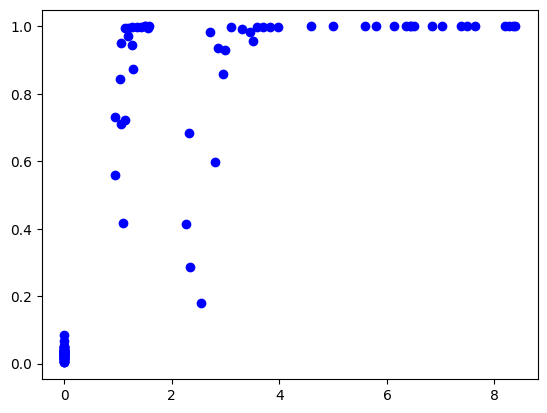

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - acc: 0.9545 - loss: 0.1405 - val_acc: 0.9900 - val_loss: 0.0467
Epoch 13/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - acc: 0.9536 - loss: 0.1341
Epoch 13: val_loss improved from 0.04675 to 0.03837, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


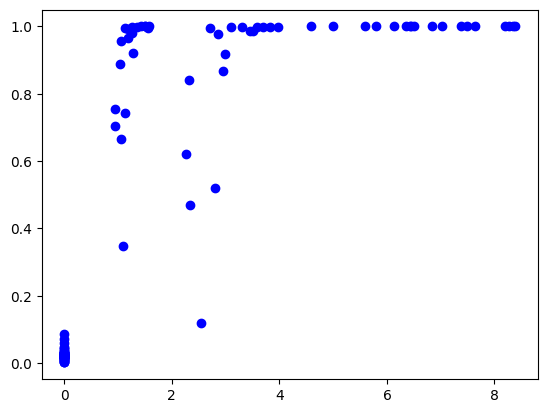

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - acc: 0.9537 - loss: 0.1340 - val_acc: 0.9900 - val_loss: 0.0384
Epoch 14/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - acc: 0.9572 - loss: 0.1224
Epoch 14: val_loss did not improve from 0.03837
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


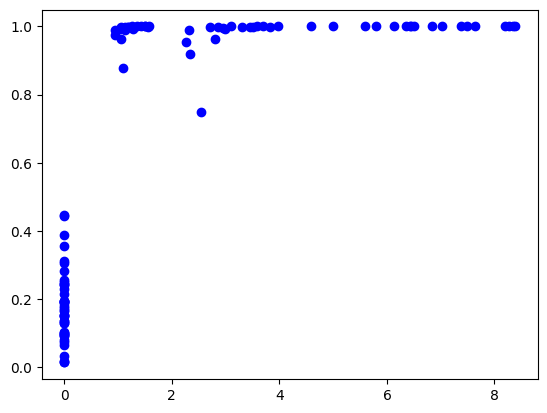

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - acc: 0.9572 - loss: 0.1224 - val_acc: 0.9800 - val_loss: 0.1148
Epoch 15/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - acc: 0.9657 - loss: 0.1105
Epoch 15: val_loss did not improve from 0.03837
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


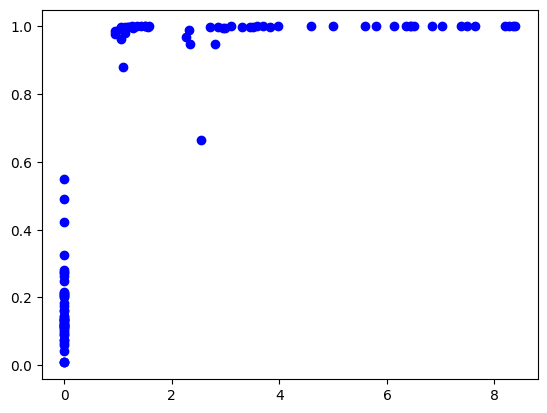

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - acc: 0.9657 - loss: 0.1105 - val_acc: 0.9800 - val_loss: 0.1002
Epoch 16/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - acc: 0.9682 - loss: 0.1012
Epoch 16: val_loss improved from 0.03837 to 0.02815, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


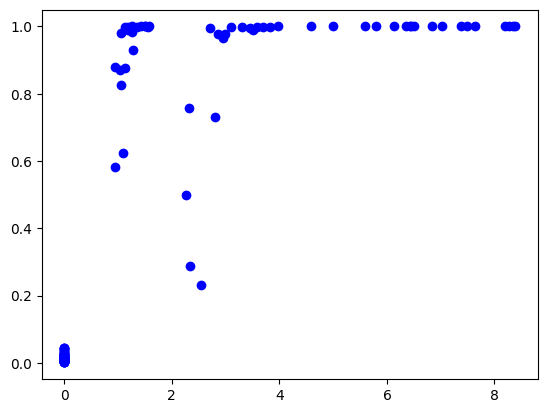

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - acc: 0.9682 - loss: 0.1011 - val_acc: 0.9900 - val_loss: 0.0282
Epoch 17/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9697 - loss: 0.0957
Epoch 17: val_loss did not improve from 0.02815
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


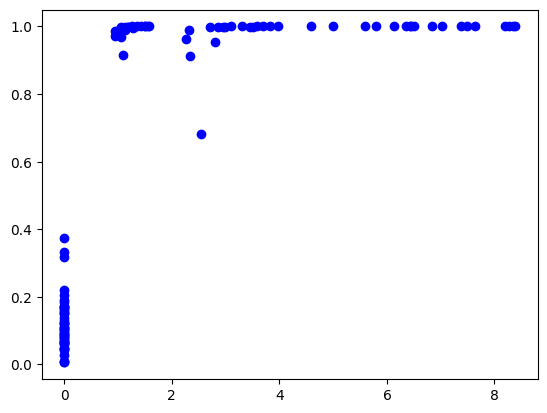

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9697 - loss: 0.0956 - val_acc: 1.0000 - val_loss: 0.0704
Epoch 18/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - acc: 0.9705 - loss: 0.0891
Epoch 18: val_loss did not improve from 0.02815
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


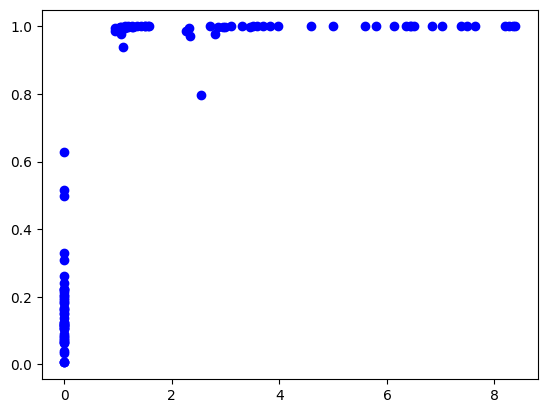

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - acc: 0.9705 - loss: 0.0891 - val_acc: 0.9800 - val_loss: 0.1056
Epoch 19/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9778 - loss: 0.0794
Epoch 19: val_loss improved from 0.02815 to 0.01769, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


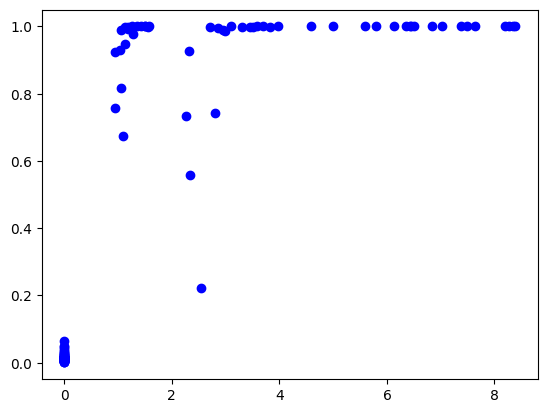

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9778 - loss: 0.0794 - val_acc: 1.0000 - val_loss: 0.0177
Epoch 20/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9762 - loss: 0.0780
Epoch 20: val_loss improved from 0.01769 to 0.01653, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


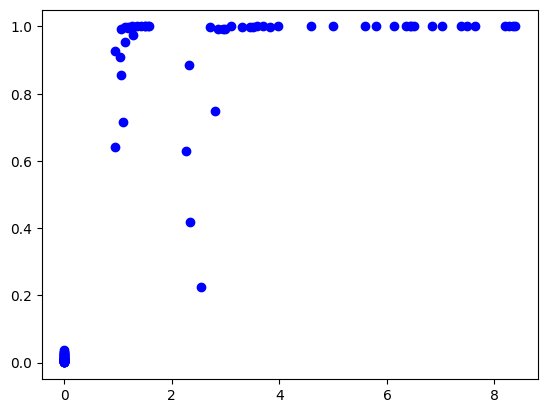

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - acc: 0.9762 - loss: 0.0779 - val_acc: 1.0000 - val_loss: 0.0165
Epoch 21/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9783 - loss: 0.0686
Epoch 21: val_loss improved from 0.01653 to 0.01590, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


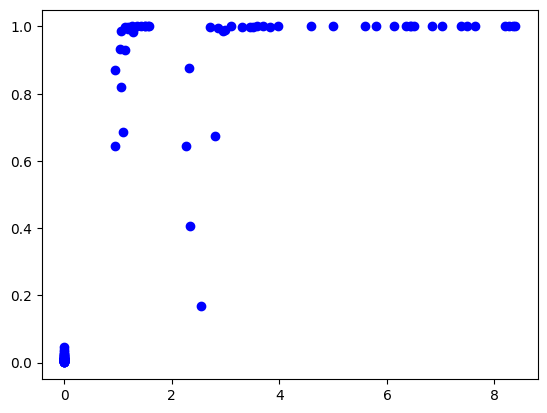

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9783 - loss: 0.0686 - val_acc: 1.0000 - val_loss: 0.0159
Epoch 22/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9818 - loss: 0.0622
Epoch 22: val_loss improved from 0.01590 to 0.01304, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


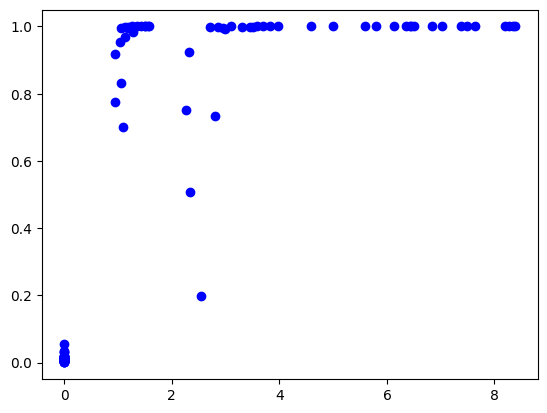

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9818 - loss: 0.0622 - val_acc: 1.0000 - val_loss: 0.0130
Epoch 23/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9808 - loss: 0.0598
Epoch 23: val_loss did not improve from 0.01304
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


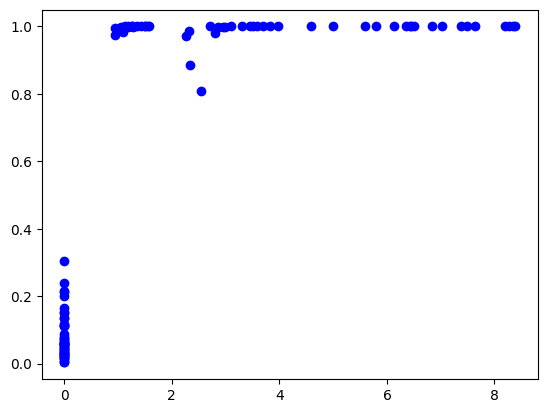

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9808 - loss: 0.0598 - val_acc: 1.0000 - val_loss: 0.0415
Epoch 24/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9837 - loss: 0.0574
Epoch 24: val_loss improved from 0.01304 to 0.01240, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


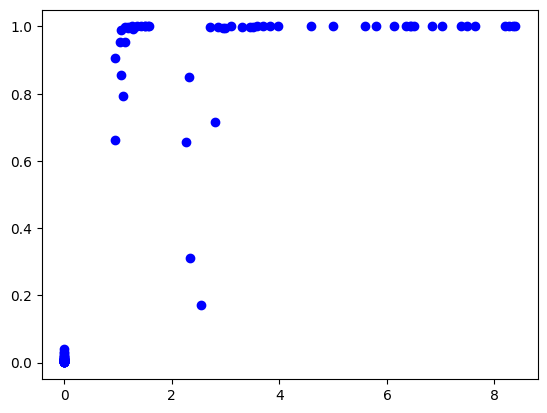

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9837 - loss: 0.0574 - val_acc: 1.0000 - val_loss: 0.0124
Epoch 25/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9857 - loss: 0.0498
Epoch 25: val_loss did not improve from 0.01240
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


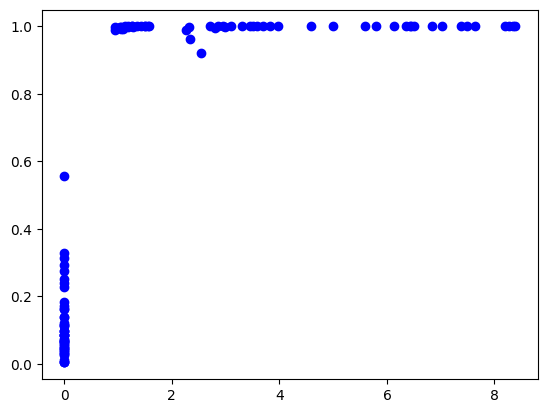

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9857 - loss: 0.0498 - val_acc: 0.9900 - val_loss: 0.0682
Epoch 26/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9862 - loss: 0.0500
Epoch 26: val_loss did not improve from 0.01240
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


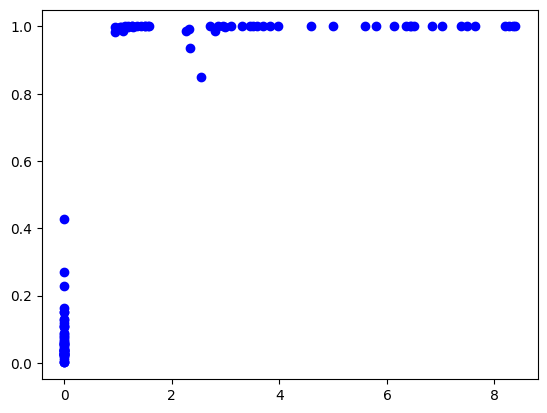

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9862 - loss: 0.0500 - val_acc: 1.0000 - val_loss: 0.0386
Epoch 27/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9882 - loss: 0.0411
Epoch 27: val_loss did not improve from 0.01240
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


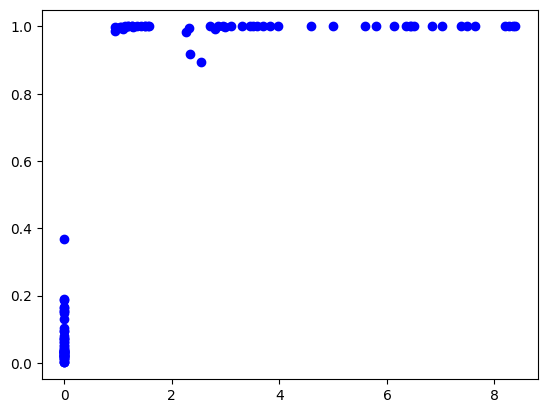

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9882 - loss: 0.0411 - val_acc: 1.0000 - val_loss: 0.0343
Epoch 28/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9906 - loss: 0.0387
Epoch 28: val_loss did not improve from 0.01240
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


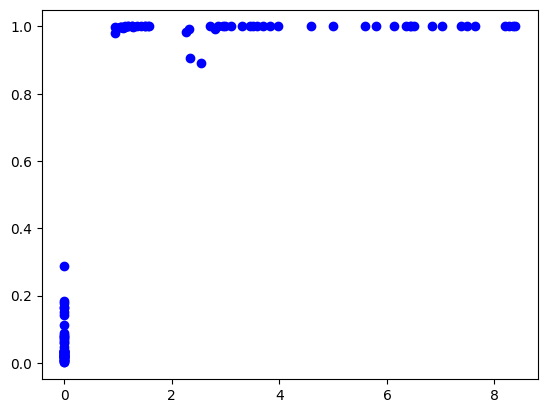

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - acc: 0.9906 - loss: 0.0387 - val_acc: 1.0000 - val_loss: 0.0264
Epoch 29/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9877 - loss: 0.0418
Epoch 29: val_loss did not improve from 0.01240
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


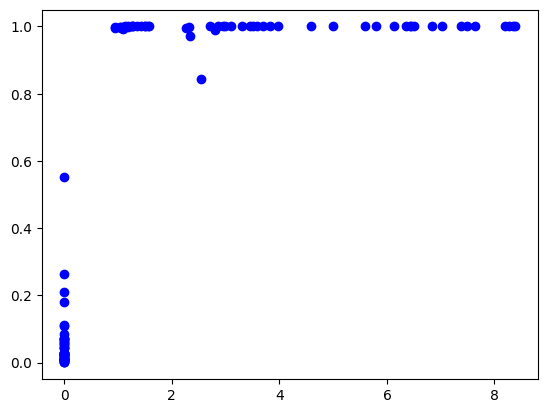

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9877 - loss: 0.0418 - val_acc: 1.0000 - val_loss: 0.0312
Epoch 30/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - acc: 0.9911 - loss: 0.0316
Epoch 30: val_loss improved from 0.01240 to 0.00551, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


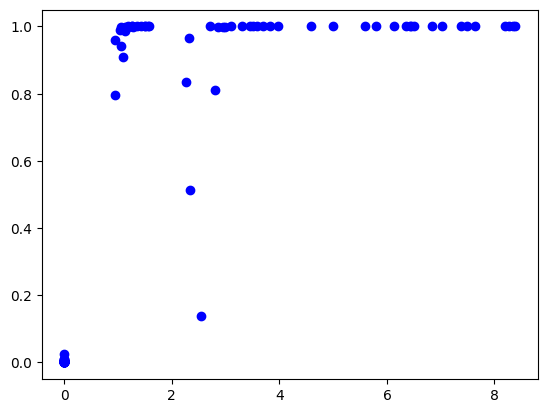

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - acc: 0.9910 - loss: 0.0316 - val_acc: 1.0000 - val_loss: 0.0055
Epoch 31/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9917 - loss: 0.0321
Epoch 31: val_loss improved from 0.00551 to 0.00446, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


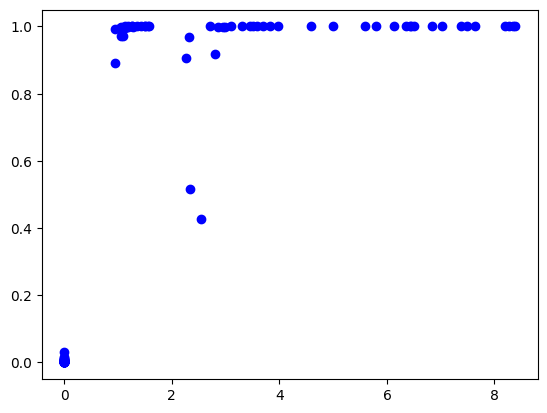

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9917 - loss: 0.0321 - val_acc: 1.0000 - val_loss: 0.0045
Epoch 32/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9912 - loss: 0.0284
Epoch 32: val_loss did not improve from 0.00446
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


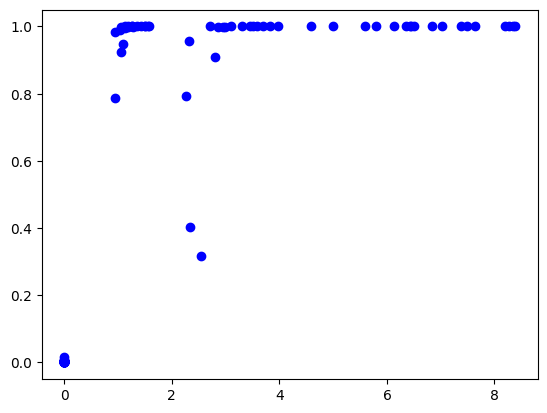

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9912 - loss: 0.0284 - val_acc: 1.0000 - val_loss: 0.0054
Epoch 33/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9937 - loss: 0.0271
Epoch 33: val_loss did not improve from 0.00446
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


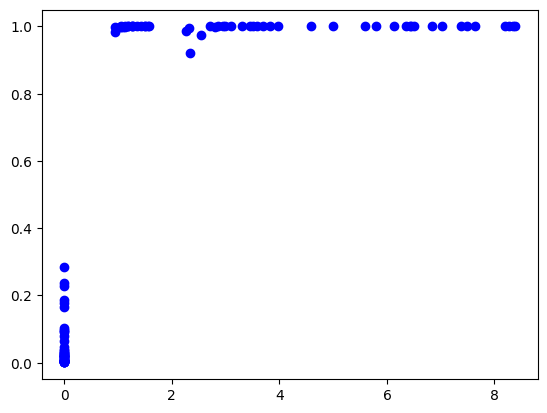

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9937 - loss: 0.0271 - val_acc: 1.0000 - val_loss: 0.0205
Epoch 34/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9930 - loss: 0.0255
Epoch 34: val_loss did not improve from 0.00446
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


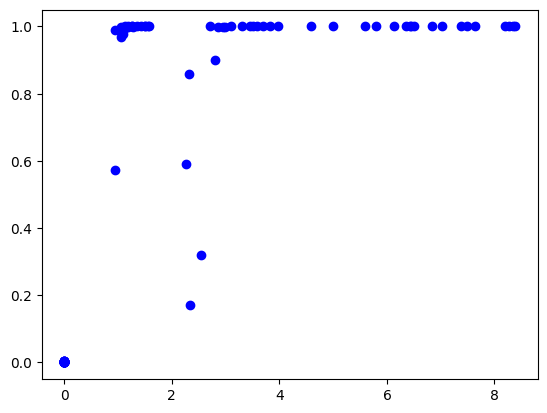

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9930 - loss: 0.0255 - val_acc: 1.0000 - val_loss: 0.0071
Epoch 35/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9927 - loss: 0.0225
Epoch 35: val_loss did not improve from 0.00446
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


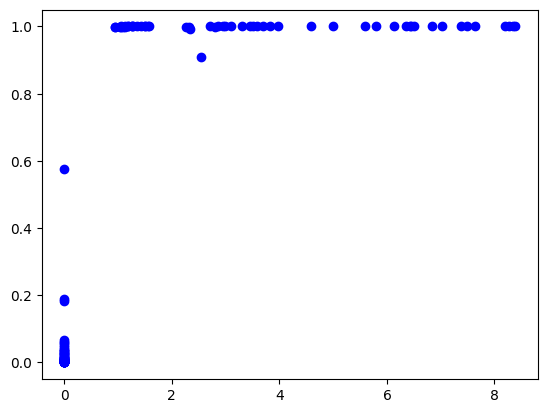

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9927 - loss: 0.0225 - val_acc: 1.0000 - val_loss: 0.0195
Epoch 36/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9950 - loss: 0.0202
Epoch 36: val_loss improved from 0.00446 to 0.00252, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


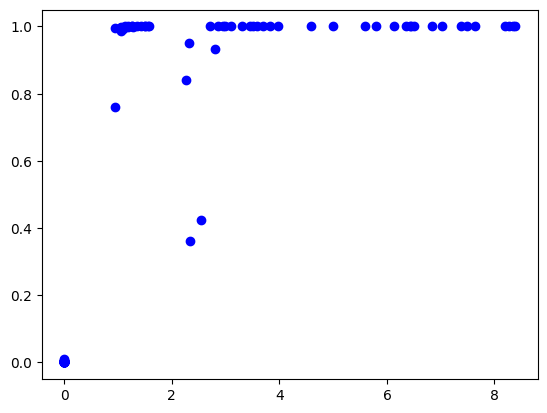

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9950 - loss: 0.0202 - val_acc: 1.0000 - val_loss: 0.0025
Epoch 37/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9947 - loss: 0.0198
Epoch 37: val_loss did not improve from 0.00252
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


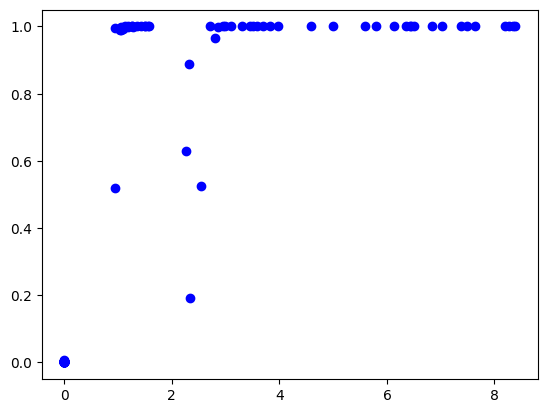

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9947 - loss: 0.0197 - val_acc: 1.0000 - val_loss: 0.0050
Epoch 38/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9928 - loss: 0.0199
Epoch 38: val_loss improved from 0.00252 to 0.00248, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


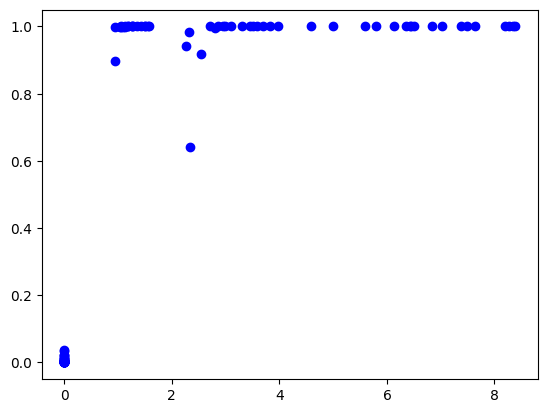

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9928 - loss: 0.0199 - val_acc: 1.0000 - val_loss: 0.0025
Epoch 39/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9952 - loss: 0.0189
Epoch 39: val_loss did not improve from 0.00248
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


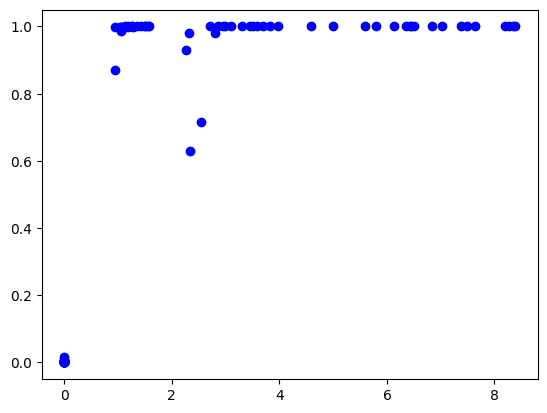

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9952 - loss: 0.0189 - val_acc: 1.0000 - val_loss: 0.0030
Epoch 40/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9954 - loss: 0.0155
Epoch 40: val_loss improved from 0.00248 to 0.00229, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


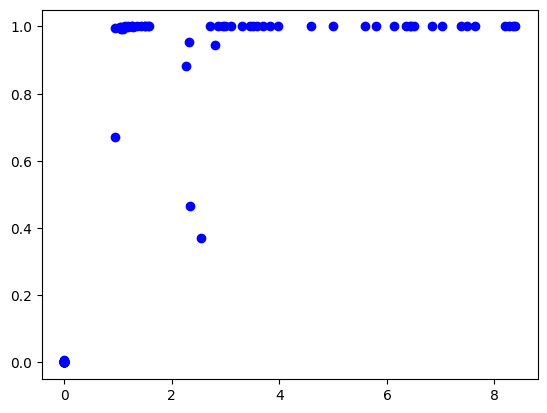

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - acc: 0.9954 - loss: 0.0155 - val_acc: 1.0000 - val_loss: 0.0023
Epoch 41/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9970 - loss: 0.0138
Epoch 41: val_loss did not improve from 0.00229
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


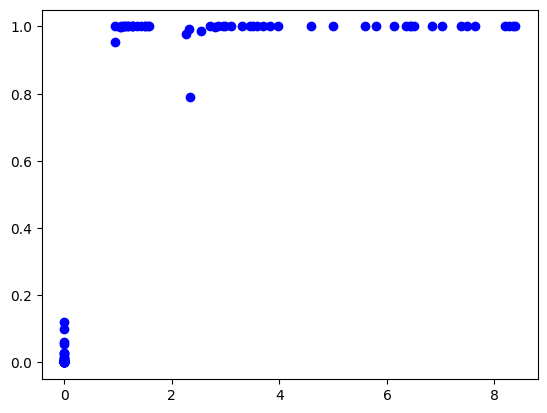

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9970 - loss: 0.0138 - val_acc: 1.0000 - val_loss: 0.0046
Epoch 42/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9972 - loss: 0.0122
Epoch 42: val_loss did not improve from 0.00229
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


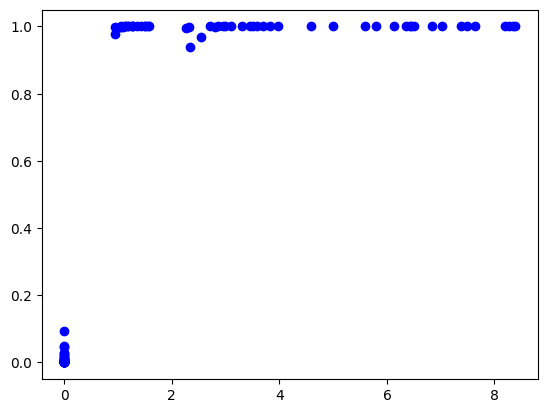

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9972 - loss: 0.0122 - val_acc: 1.0000 - val_loss: 0.0033
Epoch 43/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9964 - loss: 0.0124
Epoch 43: val_loss did not improve from 0.00229
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


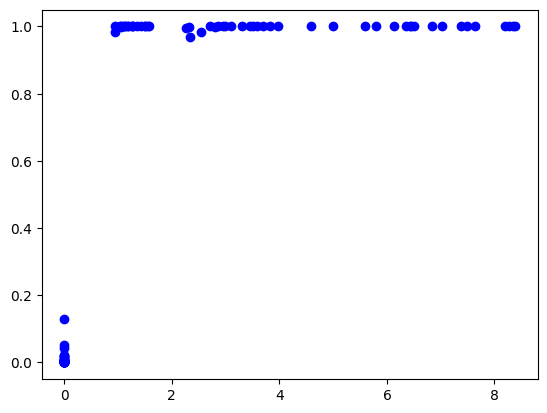

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9964 - loss: 0.0124 - val_acc: 1.0000 - val_loss: 0.0027
Epoch 44/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9977 - loss: 0.0110
Epoch 44: val_loss improved from 0.00229 to 0.00197, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


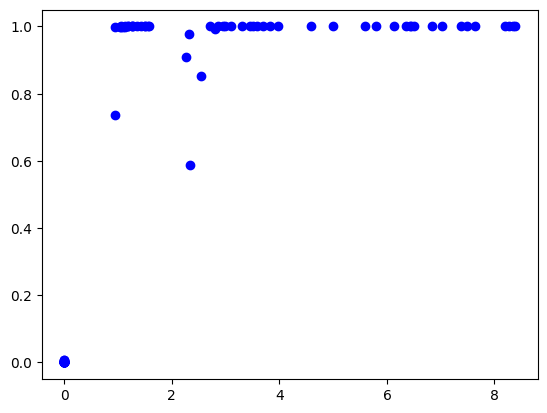

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9977 - loss: 0.0110 - val_acc: 1.0000 - val_loss: 0.0020
Epoch 45/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9963 - loss: 0.0141
Epoch 45: val_loss did not improve from 0.00197
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


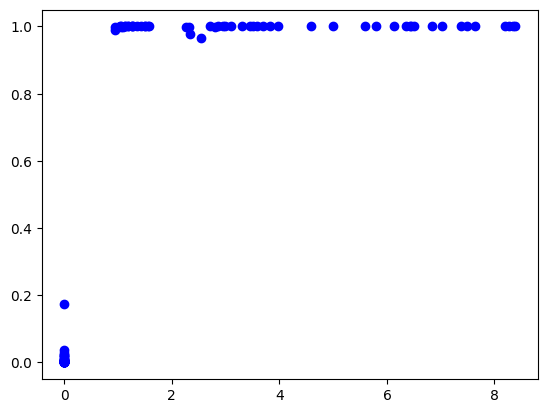

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9963 - loss: 0.0141 - val_acc: 1.0000 - val_loss: 0.0032
Epoch 46/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9983 - loss: 0.0099
Epoch 46: val_loss did not improve from 0.00197
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


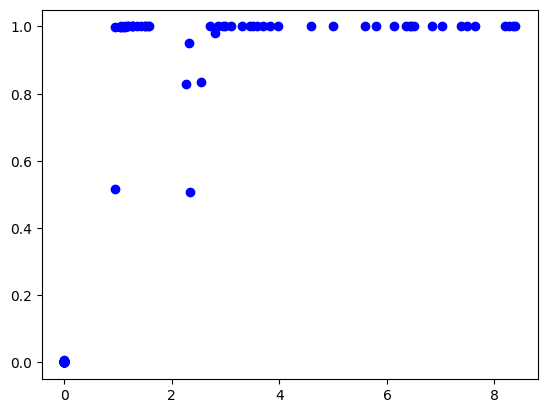

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9983 - loss: 0.0100 - val_acc: 1.0000 - val_loss: 0.0027
Epoch 47/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9982 - loss: 0.0078
Epoch 47: val_loss did not improve from 0.00197
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


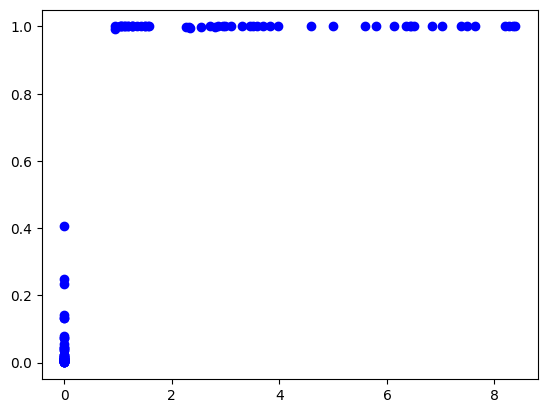

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9982 - loss: 0.0078 - val_acc: 1.0000 - val_loss: 0.0164
Epoch 48/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9983 - loss: 0.0099
Epoch 48: val_loss did not improve from 0.00197
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


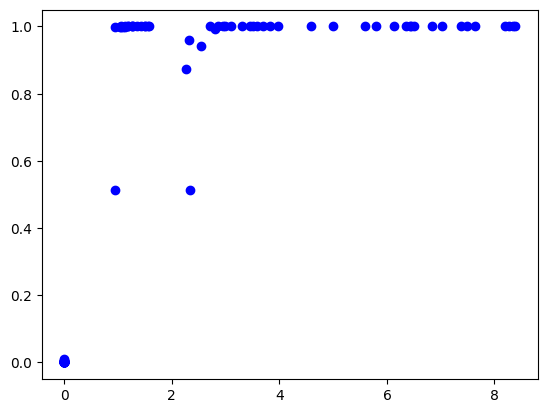

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - acc: 0.9983 - loss: 0.0099 - val_acc: 1.0000 - val_loss: 0.0030
Epoch 49/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9985 - loss: 0.0076
Epoch 49: val_loss did not improve from 0.00197
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


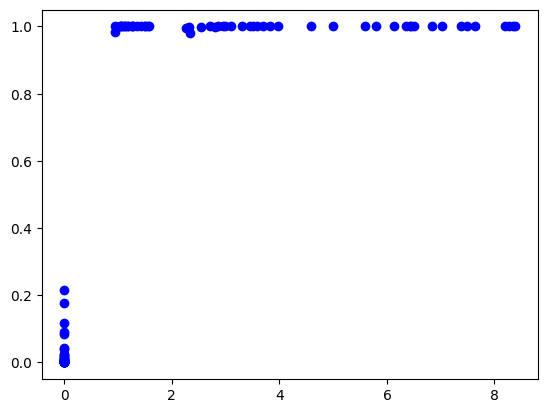

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9985 - loss: 0.0076 - val_acc: 1.0000 - val_loss: 0.0086
Epoch 50/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9976 - loss: 0.0093
Epoch 50: val_loss improved from 0.00197 to 0.00104, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


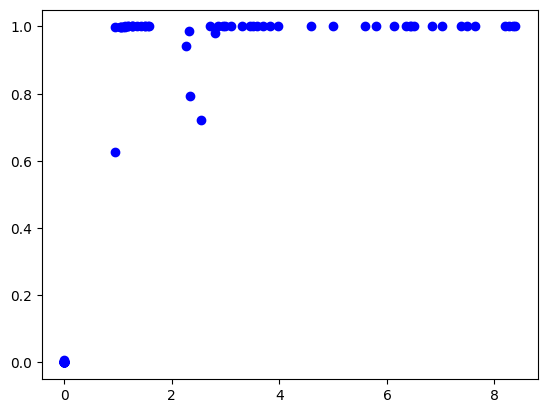

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - acc: 0.9976 - loss: 0.0093 - val_acc: 1.0000 - val_loss: 0.0010
Epoch 51/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9979 - loss: 0.0074
Epoch 51: val_loss did not improve from 0.00104
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


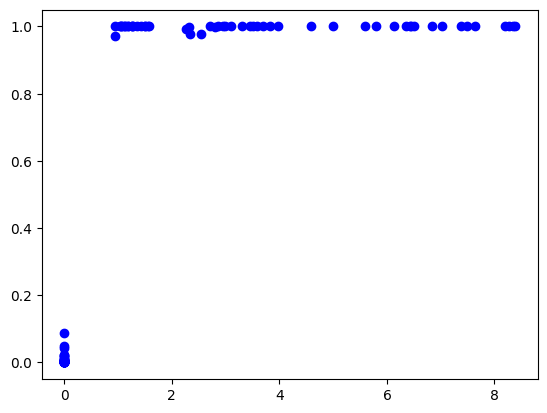

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - acc: 0.9979 - loss: 0.0074 - val_acc: 1.0000 - val_loss: 0.0019
Epoch 52/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9975 - loss: 0.0077
Epoch 52: val_loss did not improve from 0.00104
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


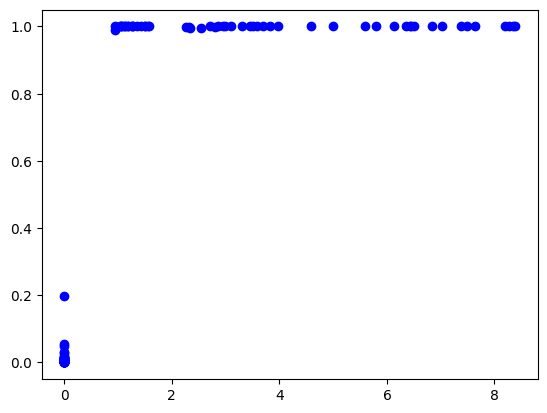

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9975 - loss: 0.0077 - val_acc: 1.0000 - val_loss: 0.0037
Epoch 53/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9988 - loss: 0.0063
Epoch 53: val_loss did not improve from 0.00104
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


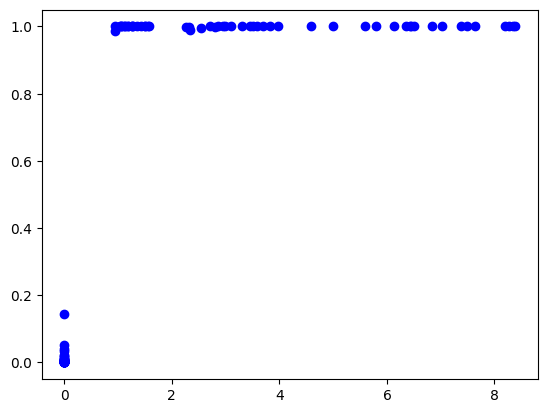

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - acc: 0.9988 - loss: 0.0063 - val_acc: 1.0000 - val_loss: 0.0028
Epoch 54/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9989 - loss: 0.0054
Epoch 54: val_loss improved from 0.00104 to 0.00051, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


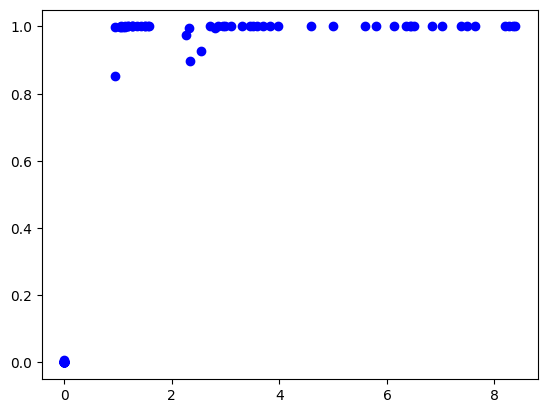

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9989 - loss: 0.0054 - val_acc: 1.0000 - val_loss: 5.0822e-04
Epoch 55/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9989 - loss: 0.0059
Epoch 55: val_loss did not improve from 0.00051
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


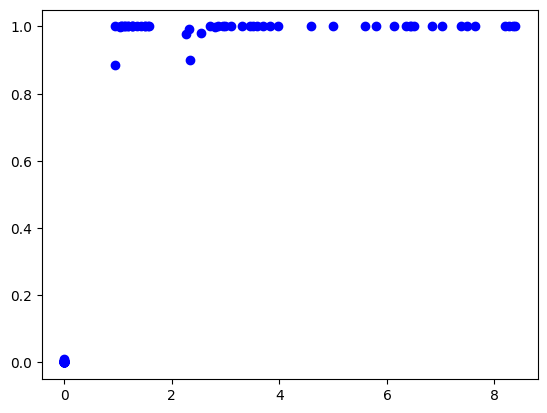

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9989 - loss: 0.0059 - val_acc: 1.0000 - val_loss: 5.7345e-04
Epoch 56/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9961 - loss: 0.0087
Epoch 56: val_loss did not improve from 0.00051
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


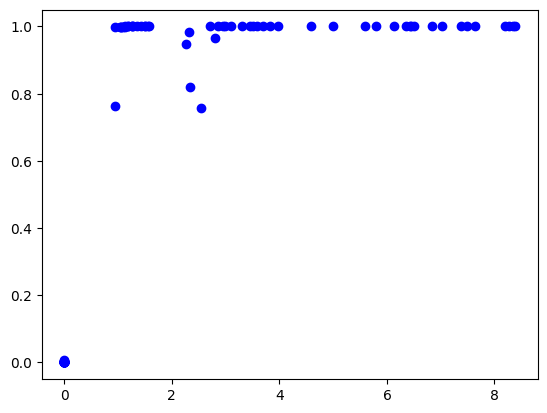

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9962 - loss: 0.0087 - val_acc: 1.0000 - val_loss: 7.3189e-04
Epoch 57/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9987 - loss: 0.0055
Epoch 57: val_loss did not improve from 0.00051
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


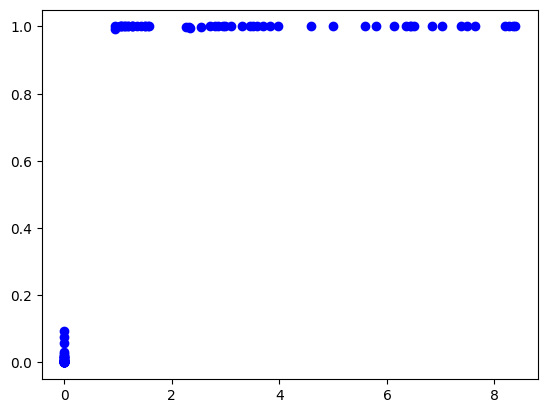

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9987 - loss: 0.0056 - val_acc: 1.0000 - val_loss: 0.0041
Epoch 58/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9997 - loss: 0.0038
Epoch 58: val_loss did not improve from 0.00051
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


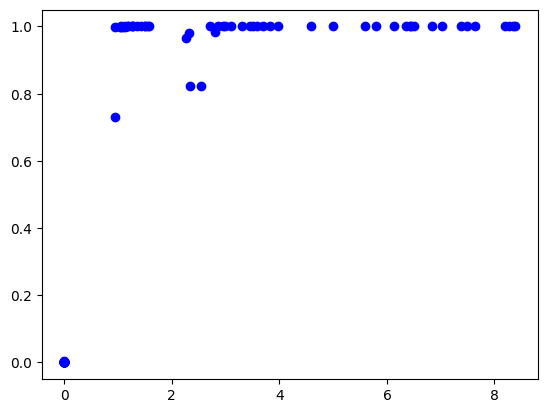

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9997 - loss: 0.0038 - val_acc: 1.0000 - val_loss: 9.8927e-04
Epoch 59/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9992 - loss: 0.0038
Epoch 59: val_loss improved from 0.00051 to 0.00046, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


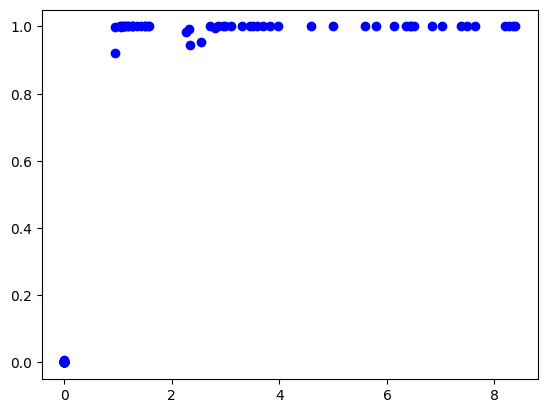

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9992 - loss: 0.0038 - val_acc: 1.0000 - val_loss: 4.5948e-04
Epoch 60/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9993 - loss: 0.0047
Epoch 60: val_loss did not improve from 0.00046
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


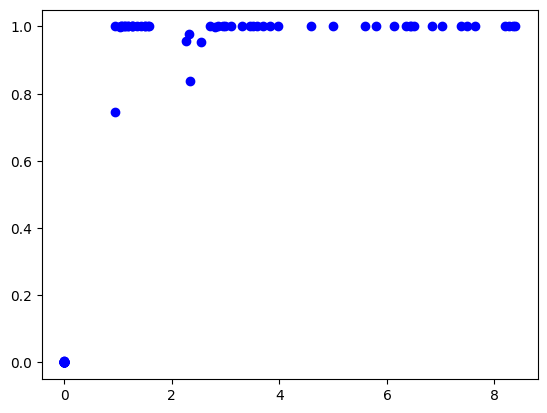

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9993 - loss: 0.0047 - val_acc: 1.0000 - val_loss: 8.2034e-04
Epoch 61/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9985 - loss: 0.0053
Epoch 61: val_loss did not improve from 0.00046
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


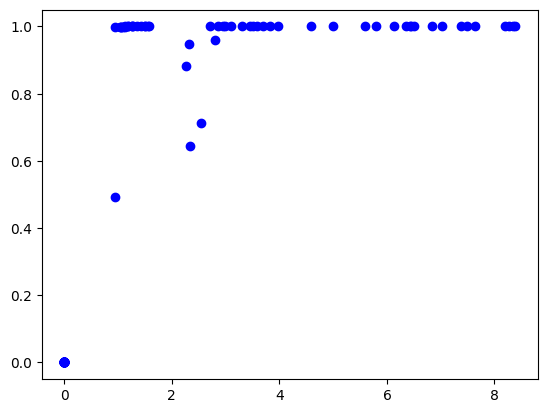

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9985 - loss: 0.0053 - val_acc: 1.0000 - val_loss: 0.0033
Epoch 62/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9995 - loss: 0.0037
Epoch 62: val_loss improved from 0.00046 to 0.00031, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


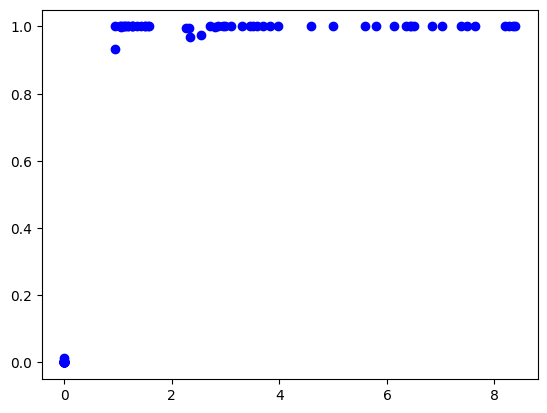

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - acc: 0.9995 - loss: 0.0037 - val_acc: 1.0000 - val_loss: 3.1009e-04
Epoch 63/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9994 - loss: 0.0042
Epoch 63: val_loss did not improve from 0.00031
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


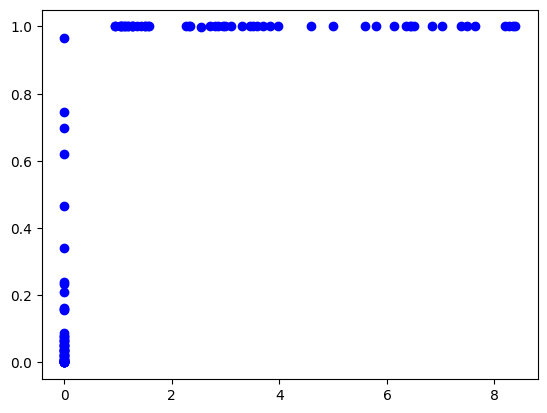

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9994 - loss: 0.0042 - val_acc: 0.9400 - val_loss: 0.1072
Epoch 64/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9983 - loss: 0.0070
Epoch 64: val_loss did not improve from 0.00031
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


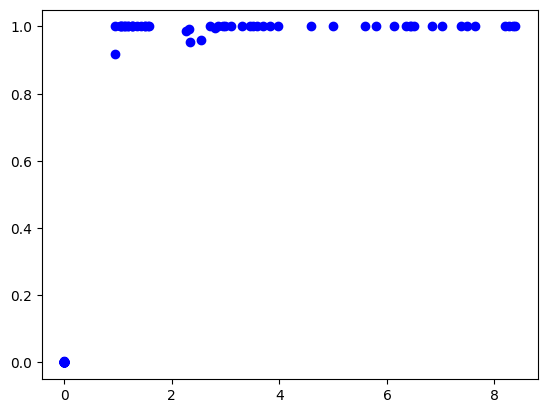

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9983 - loss: 0.0070 - val_acc: 1.0000 - val_loss: 4.2131e-04
Epoch 65/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9999 - loss: 0.0027
Epoch 65: val_loss did not improve from 0.00031
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


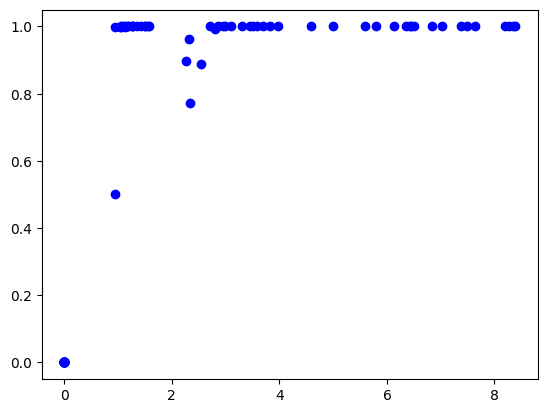

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9999 - loss: 0.0027 - val_acc: 1.0000 - val_loss: 0.0015
Epoch 66/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9996 - loss: 0.0032
Epoch 66: val_loss did not improve from 0.00031
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


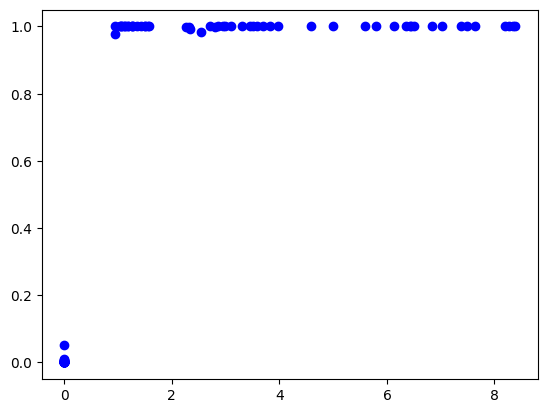

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - acc: 0.9996 - loss: 0.0032 - val_acc: 1.0000 - val_loss: 7.2072e-04
Epoch 67/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9995 - loss: 0.0029
Epoch 67: val_loss did not improve from 0.00031
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


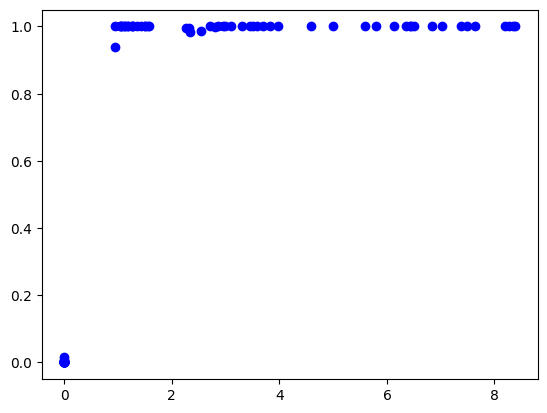

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9995 - loss: 0.0029 - val_acc: 1.0000 - val_loss: 5.3526e-04
Epoch 68/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9996 - loss: 0.0025
Epoch 68: val_loss did not improve from 0.00031
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


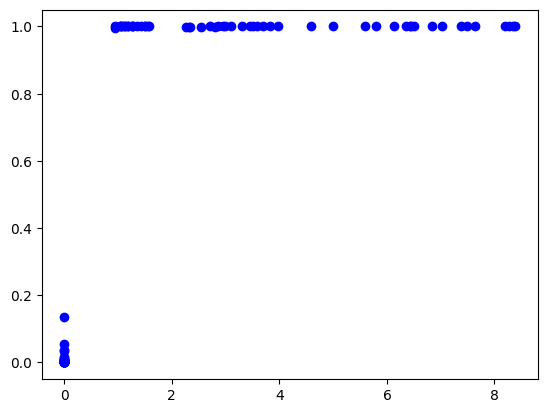

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9996 - loss: 0.0025 - val_acc: 1.0000 - val_loss: 0.0027
Epoch 69/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9988 - loss: 0.0054
Epoch 69: val_loss did not improve from 0.00031
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


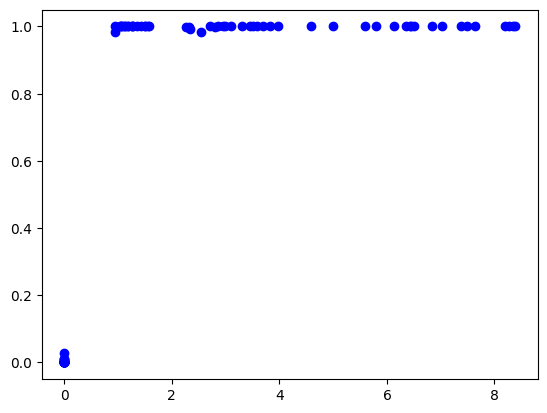

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9988 - loss: 0.0054 - val_acc: 1.0000 - val_loss: 6.3506e-04
Epoch 70/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9832 - loss: 0.0021
Epoch 70: val_loss did not improve from 0.00031
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


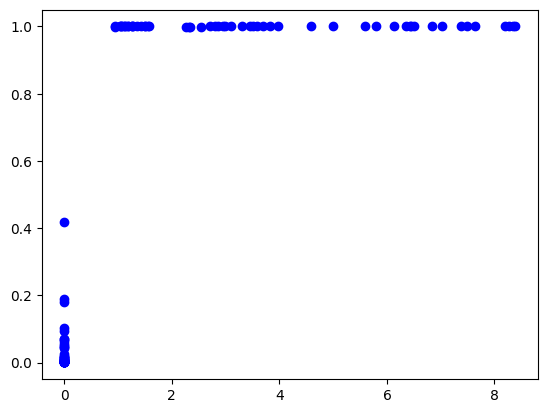

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9835 - loss: 0.0021 - val_acc: 1.0000 - val_loss: 0.0183
Epoch 71/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9998 - loss: 0.0042
Epoch 71: val_loss did not improve from 0.00031
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


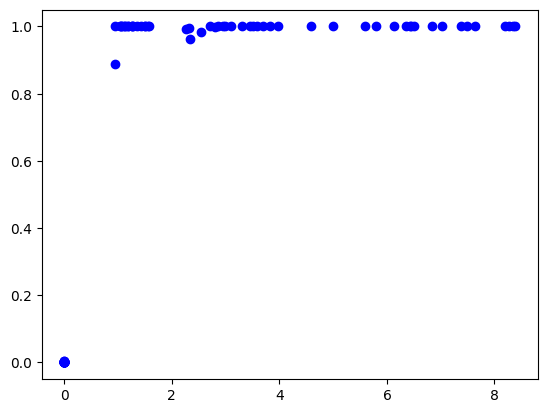

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - acc: 0.9998 - loss: 0.0042 - val_acc: 1.0000 - val_loss: 3.1383e-04
Epoch 72/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9992 - loss: 0.0033
Epoch 72: val_loss did not improve from 0.00031
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


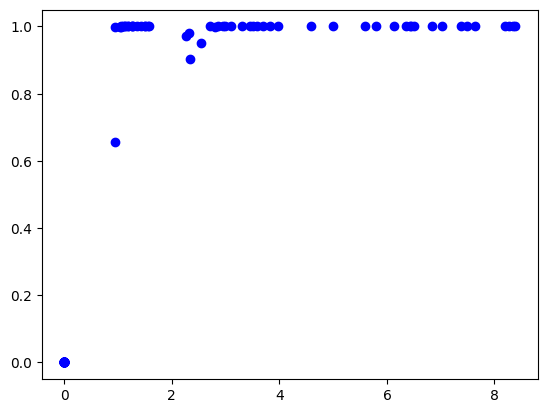

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9992 - loss: 0.0033 - val_acc: 1.0000 - val_loss: 8.9545e-04
Epoch 73/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9998 - loss: 0.0021
Epoch 73: val_loss did not improve from 0.00031
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


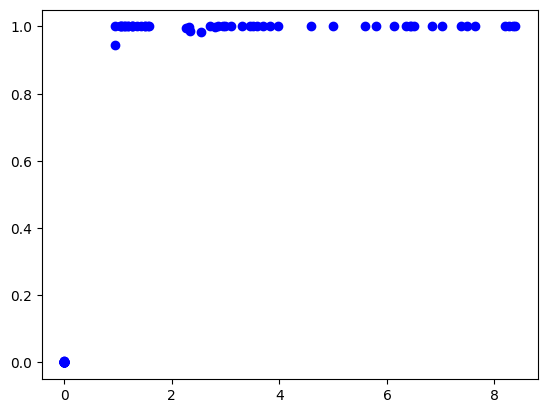

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - acc: 0.9998 - loss: 0.0021 - val_acc: 1.0000 - val_loss: 3.1191e-04
Epoch 74/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9996 - loss: 0.0022
Epoch 74: val_loss did not improve from 0.00031
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


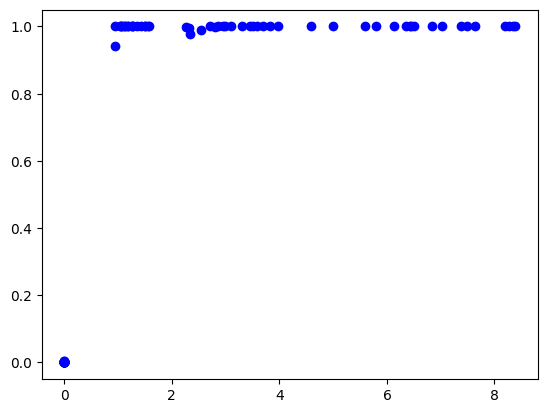

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9996 - loss: 0.0022 - val_acc: 1.0000 - val_loss: 4.1461e-04
Epoch 75/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9998 - loss: 0.0018
Epoch 75: val_loss improved from 0.00031 to 0.00030, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


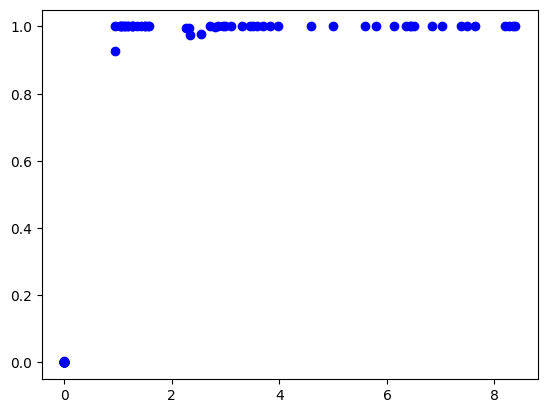

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9998 - loss: 0.0018 - val_acc: 1.0000 - val_loss: 3.0083e-04
Epoch 76/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9999 - loss: 0.0028
Epoch 76: val_loss did not improve from 0.00030
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


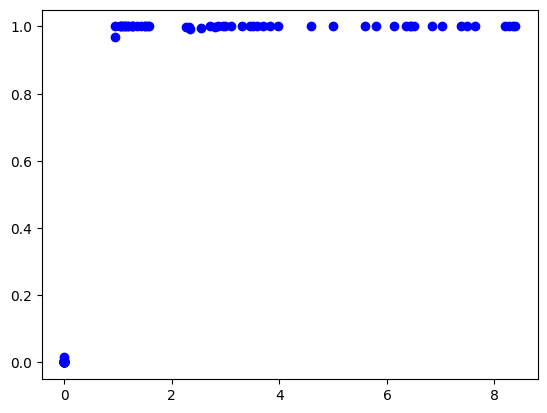

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9999 - loss: 0.0028 - val_acc: 1.0000 - val_loss: 6.8144e-04
Epoch 77/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9993 - loss: 0.0027
Epoch 77: val_loss did not improve from 0.00030
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


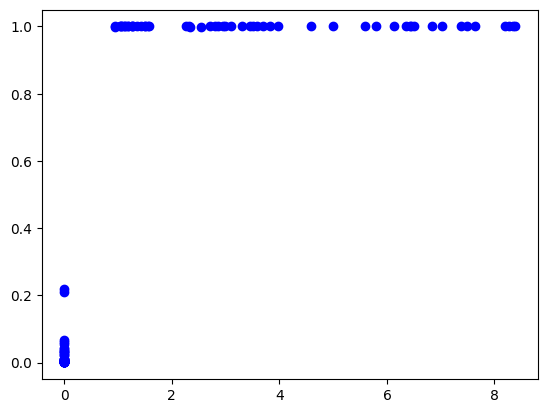

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9993 - loss: 0.0027 - val_acc: 1.0000 - val_loss: 0.0158
Epoch 78/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9997 - loss: 0.0024
Epoch 78: val_loss did not improve from 0.00030
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


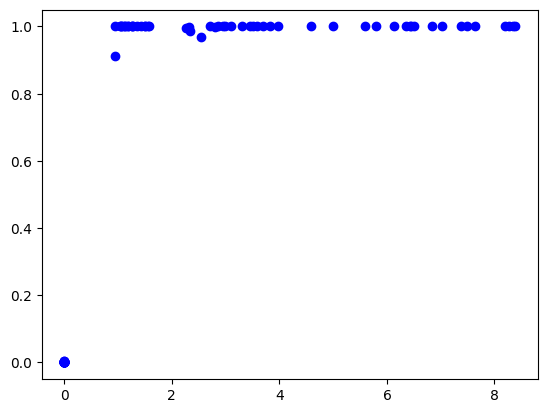

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9997 - loss: 0.0024 - val_acc: 1.0000 - val_loss: 3.0757e-04
Epoch 79/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9996 - loss: 0.0019
Epoch 79: val_loss did not improve from 0.00030
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


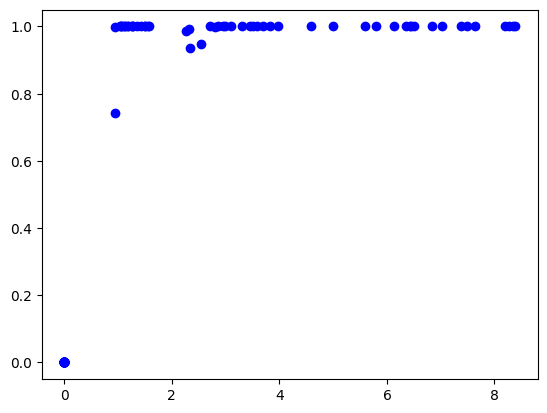

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9996 - loss: 0.0019 - val_acc: 1.0000 - val_loss: 5.0285e-04
Epoch 80/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9998 - loss: 0.0017
Epoch 80: val_loss did not improve from 0.00030
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


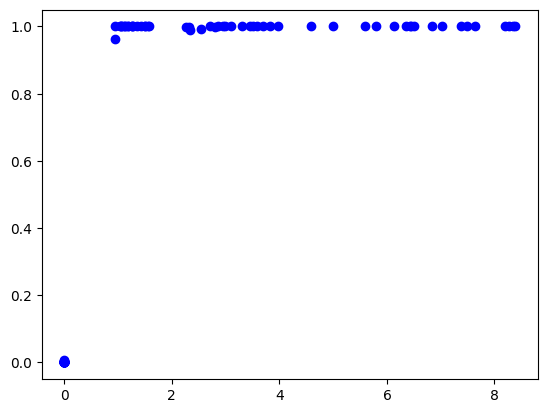

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9998 - loss: 0.0017 - val_acc: 1.0000 - val_loss: 3.7635e-04
Epoch 81/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 1.0000 - loss: 0.0015
Epoch 81: val_loss did not improve from 0.00030
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


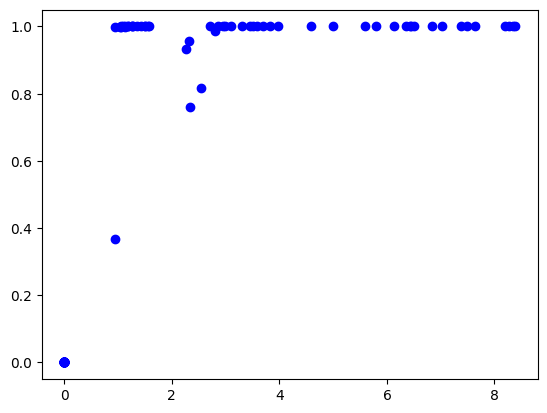

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 1.0000 - loss: 0.0015 - val_acc: 1.0000 - val_loss: 0.0028
Epoch 82/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9995 - loss: 0.0018
Epoch 82: val_loss did not improve from 0.00030
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


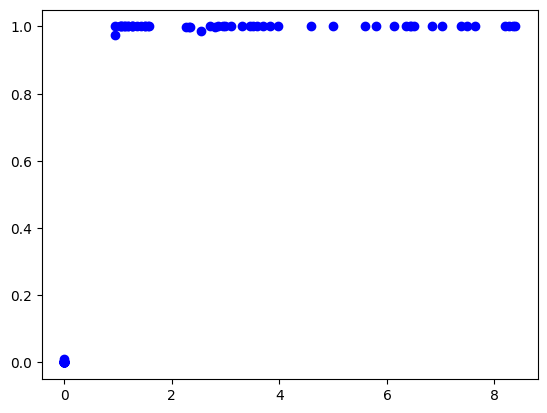

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9995 - loss: 0.0018 - val_acc: 1.0000 - val_loss: 4.2084e-04
Epoch 83/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 1.0000 - loss: 0.0013
Epoch 83: val_loss did not improve from 0.00030
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


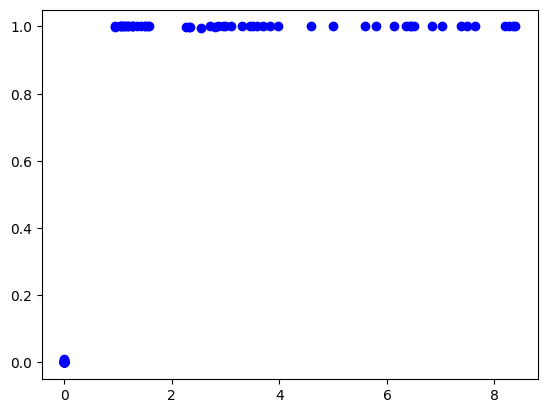

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9999 - loss: 0.0013 - val_acc: 1.0000 - val_loss: 4.9971e-04
Epoch 84/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 1.0000 - loss: 0.0010
Epoch 84: val_loss did not improve from 0.00030
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


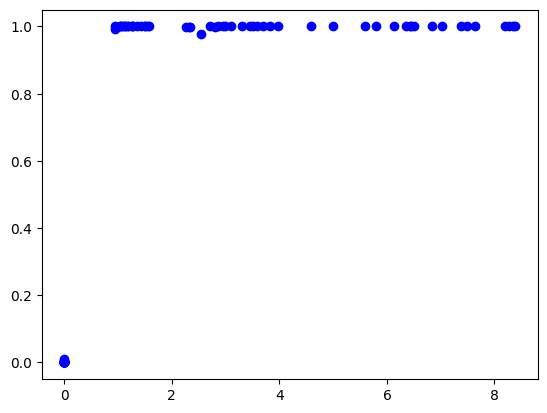

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - acc: 1.0000 - loss: 0.0010 - val_acc: 1.0000 - val_loss: 3.8618e-04
Epoch 85/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9999 - loss: 9.4362e-04
Epoch 85: val_loss did not improve from 0.00030
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


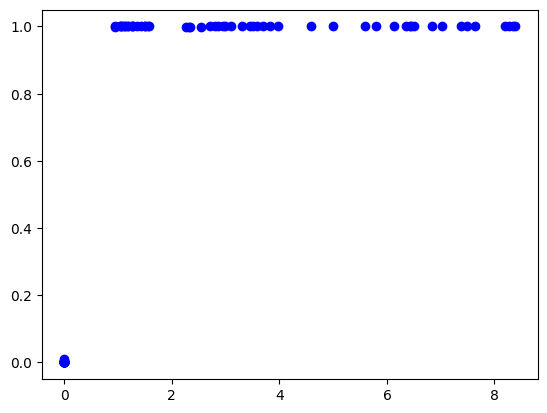

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9999 - loss: 9.4759e-04 - val_acc: 1.0000 - val_loss: 6.3736e-04
Epoch 86/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9999 - loss: 6.7761e-04
Epoch 86: val_loss improved from 0.00030 to 0.00016, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


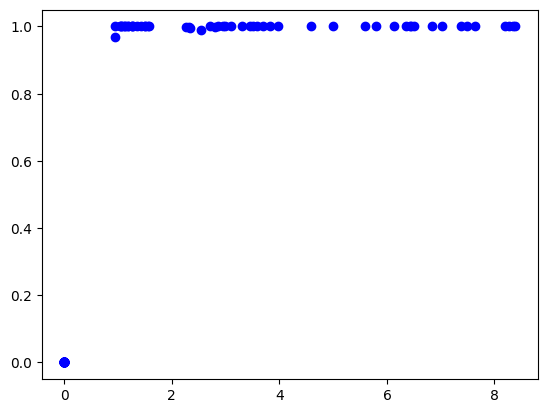

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9999 - loss: 6.8080e-04 - val_acc: 1.0000 - val_loss: 1.5688e-04
Epoch 87/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 1.0000 - loss: 0.0013
Epoch 87: val_loss did not improve from 0.00016
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


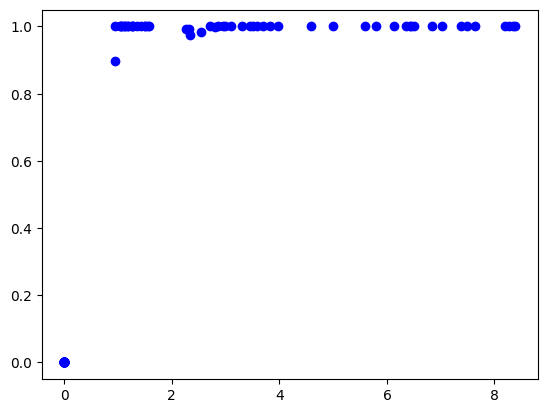

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 1.0000 - loss: 0.0013 - val_acc: 1.0000 - val_loss: 2.8485e-04
Epoch 88/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9999 - loss: 7.3025e-04
Epoch 88: val_loss did not improve from 0.00016
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


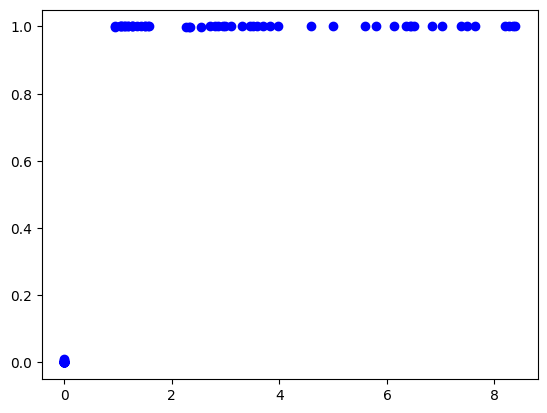

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9999 - loss: 7.3191e-04 - val_acc: 1.0000 - val_loss: 4.8356e-04
Epoch 89/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9993 - loss: 0.0019
Epoch 89: val_loss did not improve from 0.00016
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


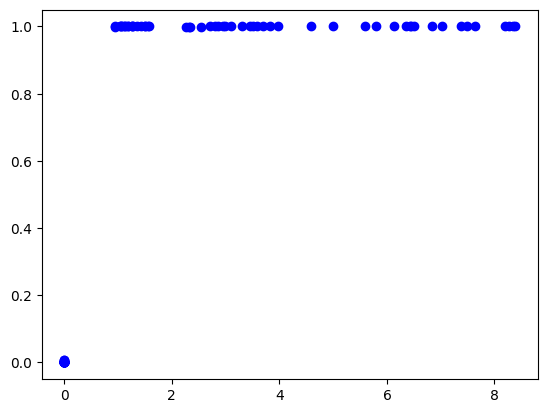

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9993 - loss: 0.0019 - val_acc: 1.0000 - val_loss: 3.4189e-04
Epoch 90/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9999 - loss: 0.0012
Epoch 90: val_loss improved from 0.00016 to 0.00011, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


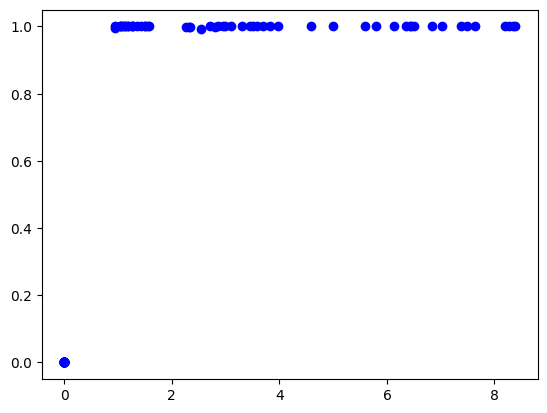

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9999 - loss: 0.0012 - val_acc: 1.0000 - val_loss: 1.0879e-04
Epoch 91/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 1.0000 - loss: 5.6600e-04
Epoch 91: val_loss improved from 0.00011 to 0.00010, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


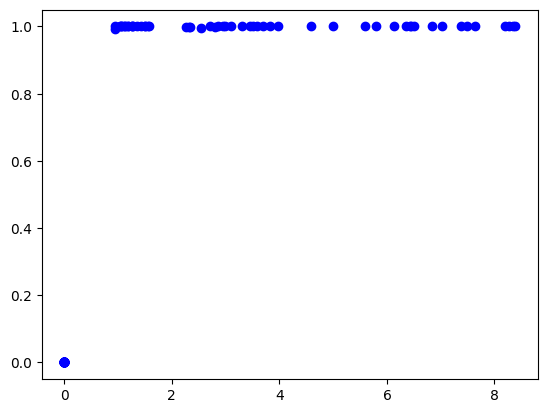

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 1.0000 - loss: 5.6655e-04 - val_acc: 1.0000 - val_loss: 1.0154e-04
Epoch 92/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9998 - loss: 0.0011
Epoch 92: val_loss did not improve from 0.00010
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


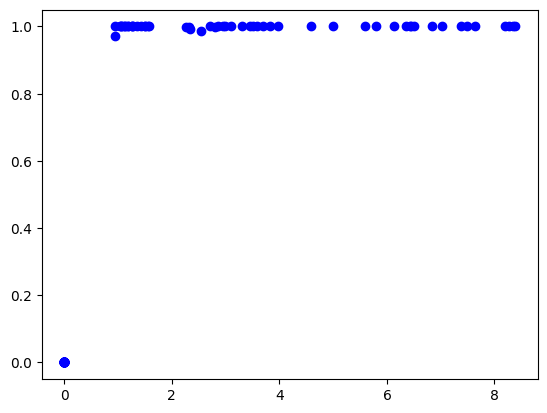

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 0.9998 - loss: 0.0011 - val_acc: 1.0000 - val_loss: 1.1227e-04
Epoch 93/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9999 - loss: 0.0011
Epoch 93: val_loss did not improve from 0.00010
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


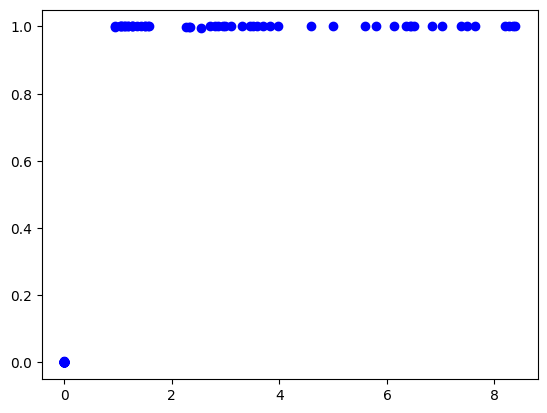

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - acc: 0.9999 - loss: 0.0011 - val_acc: 1.0000 - val_loss: 1.3969e-04
Epoch 94/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 1.0000 - loss: 3.8508e-04
Epoch 94: val_loss did not improve from 0.00010
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


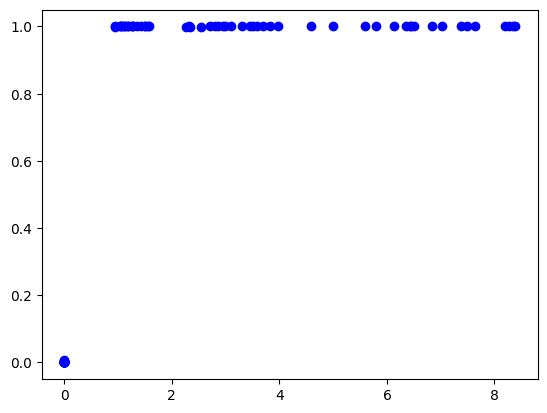

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - acc: 1.0000 - loss: 3.8726e-04 - val_acc: 1.0000 - val_loss: 2.1993e-04
Epoch 95/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9998 - loss: 7.1693e-04
Epoch 95: val_loss did not improve from 0.00010
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


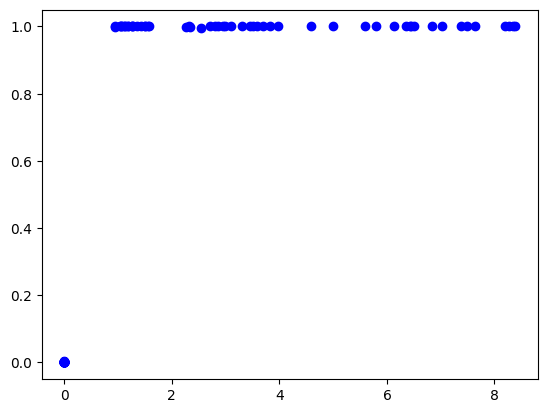

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9998 - loss: 7.2209e-04 - val_acc: 1.0000 - val_loss: 1.2919e-04
Epoch 96/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 1.0000 - loss: 3.9917e-04
Epoch 96: val_loss improved from 0.00010 to 0.00005, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


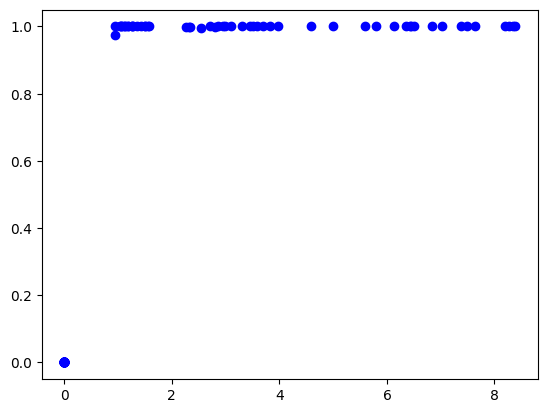

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - acc: 1.0000 - loss: 3.9835e-04 - val_acc: 1.0000 - val_loss: 4.5791e-05
Epoch 97/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.9995 - loss: 0.0018
Epoch 97: val_loss did not improve from 0.00005
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


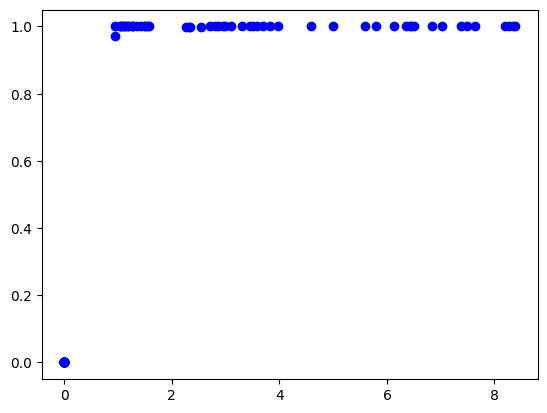

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - acc: 0.9995 - loss: 0.0017 - val_acc: 1.0000 - val_loss: 7.5705e-05
Epoch 98/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.9997 - loss: 7.8520e-04
Epoch 98: val_loss did not improve from 0.00005
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


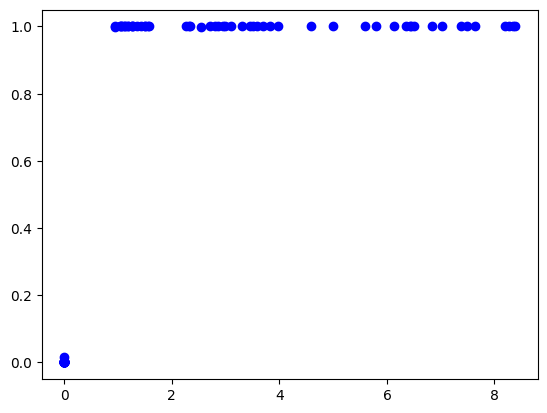

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9997 - loss: 7.8541e-04 - val_acc: 1.0000 - val_loss: 5.2664e-04
Epoch 99/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 1.0000 - loss: 5.8176e-04
Epoch 99: val_loss improved from 0.00005 to 0.00004, saving model to modelcpntbcb525fa-5829-4e58-a32c-c7801ed859d5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


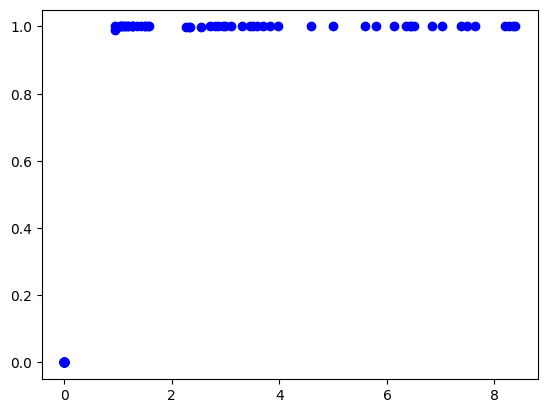

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - acc: 1.0000 - loss: 5.7850e-04 - val_acc: 1.0000 - val_loss: 3.6233e-05
Epoch 100/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9995 - loss: 0.0013
Epoch 100: val_loss did not improve from 0.00004
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


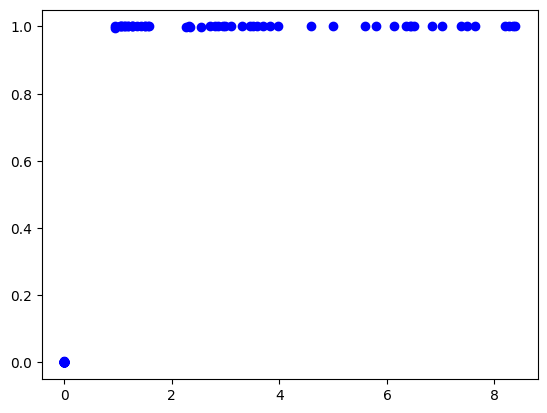

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - acc: 0.9995 - loss: 0.0013 - val_acc: 1.0000 - val_loss: 6.7899e-05
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


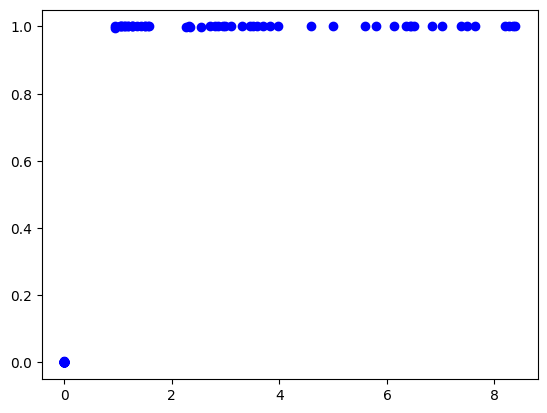

[[0.0000000e+00 0.0000000e+00 2.7644553e-06]
 [0.0000000e+00 0.0000000e+00 7.4868643e-05]
 [0.0000000e+00 0.0000000e+00 1.7480325e-07]
 [1.0000000e+00 1.4357594e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 4.1685373e-05]
 [0.0000000e+00 0.0000000e+00 3.2065334e-05]
 [0.0000000e+00 0.0000000e+00 4.5933840e-03]
 [1.0000000e+00 3.9754386e+00 1.0000000e+00]
 [1.0000000e+00 8.3844995e+00 1.0000000e+00]
 [1.0000000e+00 3.8163941e+00 1.0000000e+00]
 [1.0000000e+00 6.8416162e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 8.5506417e-06]
 [0.0000000e+00 0.0000000e+00 2.4995223e-05]
 [0.0000000e+00 0.0000000e+00 9.3234878e-05]
 [1.0000000e+00 9.4440591e-01 9.9658823e-01]
 [1.0000000e+00 7.4808564e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 7.7740941e-07]
 [1.0000000e+00 2.3222325e+00 9.9994743e-01]
 [1.0000000e+00 3.3124421e+00 1.0000000e+00]
 [1.0000000e+00 5.8017273e+00 1.0000000e+00]
 [1.0000000e+00 6.1342368e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 8.0303435e-05]
 [0.000000

In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

'''
    This code trains a convolutional network to find flaws in
    ultrasonic data. See https://arxiv.org/abs/1903.11399 for details.
'''

from __future__ import print_function
import keras
from keras import backend as K
from keras import Input, layers
from keras import Model

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.interactive(True)

from os import listdir
from os.path import isfile, join
import uuid
import time


w,h = 256,256                       # initial data size
window = 7                          # window for the first max-pool operation

run_uuid = uuid.uuid4()             #unique identifier is generated for each run

path = "/content/drive/MyDrive/engr521_dataset/training/"          #training data path
vpath = "/content/drive/MyDrive/engr521_dataset/validation/"       #validation data path

'''     The data_generator reads raw binary UT data from the pre-processed files
        and preconditions it for ML training. '''
def data_generator( batch_size = 10):
    input_files = [f for f in listdir(path) if isfile(join( path,f)) and f.endswith('.bins') ]
    np.random.shuffle(input_files)          # we'll take random set from available data files
    input_files = input_files[0:100]        # limit to 100 files per epoch
    xs = np.empty( (0), dtype='float32')    #  input data
    ys = np.empty((0,2), dtype='float32')   #  label data
    for i in input_files:
        bxs = np.fromfile(path+i, dtype=np.uint16).astype('float32')
        bxs -= bxs.mean()
        bxs /= bxs.std() +0.00001           #avoid division by zero
        xs = np.concatenate((xs,bxs))
        bys = np.loadtxt(path + i[:-5] +'.labels')
        ys = np.concatenate((ys,bys) )

    xs = np.reshape(xs, (-1,256,256,1), 'C')

    rows = xs.shape[0]
    cursor = 0
    while True:
        start = cursor
        cursor += batch_size
        if(cursor > rows):
            cursor = 0
        bxs = xs[start:cursor,:,:,:]
        bys = ys[start:cursor,0]
        yield( (xs[start:cursor,:,:,:], ys[start:cursor,0]) )


input_tensor = Input(shape=(w,h,1))

# start with max-pool to envelop the UT-data
ib = layers.MaxPooling2D(pool_size=(window,1),  padding='valid' )(input_tensor) # MaxPooling1D would work, but we may want to pool adjacent A-scans in the future

#build the network
cb = layers.Conv2D(96,3,padding='same', activation='relu')(ib)
cb = layers.Conv2D(64,3,padding='same', activation='relu')(cb)
cb = layers.MaxPooling2D( (2,8), padding='same')(cb)

cb = layers.Conv2D(48,3,padding='same', activation='relu')(cb)
cb = layers.Conv2D(32,3,padding='same', activation='relu')(cb)
cb = layers.MaxPooling2D( (3,4), padding='same' )(cb)
cb = layers.Flatten()(cb)
cb = layers.Dense(14, activation='relu', name='RNN')(cb)
iscrack = layers.Dense(1, activation='sigmoid', name='output')(cb)


model = Model(input_tensor, iscrack)
#it was 'lr' instead of 'learning_rate' in the original code
opt = keras.optimizers.RMSprop(learning_rate=0.0001, clipnorm=1.)
model.compile(optimizer=opt, loss='binary_crossentropy' , metrics=['acc'])
model.summary()

#moved this section from below to make rxs variable available to debugCallBack class
test_uuid = "FA4DC2D8-C0D9-4ECB-A319-70F156E3AF31"
rxs = np.fromfile(vpath+test_uuid+".bins", dtype=np.uint16 ).astype('float32')
rxs -= rxs.mean()
rxs /= rxs.std()+0.0001
rxs = np.reshape( rxs, (-1,256,256,1), 'C')
rys = np.loadtxt(vpath+test_uuid+".labels", dtype=np.float32)

class DebugCallback(keras.callbacks.Callback):
#    def on_batch_end(self, batch, logs={}):
    def on_epoch_end(self, epoch, logs={} ):
        predictions = model.predict(rxs)
        res = np.concatenate((rys, predictions), -1)
        plt.plot(res[:, 1], res[:, 2], 'bo')
        plt.show()
        #plt.savefig("out.png")

debug = DebugCallback()

# callbacks = [  keras.callbacks.TensorBoard(log_dir='log', histogram_freq=1)
#              , keras.callbacks.ModelCheckpoint( 'modelcpnt'+str(run_uuid)+'.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
#              , debug ]

callbacks = [  keras.callbacks.TensorBoard(log_dir='log', histogram_freq=1)
             , keras.callbacks.ModelCheckpoint( 'modelcpnt'+str(run_uuid)+'.keras', monitor='val_loss', verbose=1, save_best_only=True) # Changed .hdf5 to .keras
             , debug ]

# Generate data for validation outside the generator function
validation_generator = data_generator(100)  # Create a generator instance
validation_data = next(validation_generator)  # Get one batch of data for validation
# Unpack the validation data
val_xs, val_ys = validation_data

#model.fit_generator(data_generator(100),epochs=100,validation_data= (xs,ys[:,0]),steps_per_epoch=60,callbacks=callbacks)
# Replace 'model.fit_generator' with 'model.fit':

#model.fit(data_generator(100), epochs=100, validation_data=(xs, ys[:, 0]), steps_per_epoch=60, callbacks=callbacks)
#updated model.fit statement
model.fit(data_generator(100), epochs=100, validation_data=(val_xs, val_ys), steps_per_epoch=60, callbacks=callbacks)


#commented 'cd' out
#cd
predictions = model.predict(rxs)
res = np.concatenate( (rys,predictions), -1 )
plt.plot(res[:,1], res[:,2], 'bo')
plt.show()
print( res )
np.savetxt('results.txt', res)

#Converted to pytorch

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import uuid
import time

path = "/content/drive/MyDrive/engr521_dataset/training/"  # training data path
vpath = "/content/drive/MyDrive/engr521_dataset/validation/"  # validation data path


# Create a Custom Dataset Class
class UTDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.input_files = [
            f
            for f in listdir(data_path)
            if isfile(join(data_path, f)) and f.endswith(".bins")
        ]
        self.input_files = self.input_files[:100]  # Limit to 100 files

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        file_path = join(self.data_path, self.input_files[idx])
        data = np.fromfile(file_path, dtype=np.uint16).astype("float32")
        data -= data.mean()
        data /= data.std() + 0.00001  # Avoid division by zero

        # Reshape to (number_of_slices, channels, height, width)
        # Each slice is treated as a separate sample
        data = data.reshape(100, 1, 256, 256)

        labels = np.loadtxt(file_path[:-5] + ".labels")[:, 0]
        # Return each slice as a separate sample with its label
        labels = labels.reshape(100, 1)  # Reshape labels to match data shape
        return torch.from_numpy(data), torch.from_numpy(labels)


# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.maxpool1 = nn.MaxPool2d(
            kernel_size=(7, 1), stride=1, padding=(0,0)
        )  # Adjust as needed , added padding to match keras padding='valid'
        self.conv1 = nn.Conv2d(1, 96, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(96, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 8), padding=0) #padding same is by default 0
        self.conv3 = nn.Conv2d(64, 48, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(48, 32, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 4), padding=0) #padding same is by default 0
        self.flatten = nn.Flatten()
        # Adjust the input size of the linear layer to match the output of the convolutional layers
        # after flattening (32*8*8 = 2048 for a single slice)
        self.fc1 = nn.Linear(
            32 * 8 * 8, 14
        )  # Adjust if needed - this is correct for a single slice
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(14, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.maxpool1(x)
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.maxpool2(x)
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.relu5(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


# Training loop

# Set up data loaders
train_dataset = UTDataset(path)
# batch_size=1 to process one .bins file (containing 100 slices) at a time
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Initialize model, optimizer, and loss function
model = CNNModel()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss

# Training loop
num_epochs = 100
losses = []  # List to store loss values for plotting
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        # data shape: (batch_size, num_slices, channels, height, width)
        # target shape: (batch_size, num_slices, 1)

        # Iterate through each slice in the batch
        for slice_idx in range(data.shape[1]):  # Iterate over slices
            slice_data = data[
                0, slice_idx
            ]  # Get data for current slice from the batch
            slice_target = target[
                0, slice_idx
            ]  # Get target for current slice from the batch

            #print("slice_data.shape:", slice_data.shape)  # Check shape (should be (1, 256, 256))
            #print("slice_target.shape:", slice_target.shape)  # Check shape (should be (1,))

            optimizer.zero_grad()
            output = model(slice_data)  # Pass individual slice to the model
            loss = criterion(
                output, slice_target.float()
            )  # Calculate loss for the slice
            loss.backward()  # Backpropagate loss
            optimizer.step()  # Update model parameters
            losses.append(loss.item())  # Append loss to the list

            print(
                f"Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}, Slice: {slice_idx+1}, Loss: {loss.item():.4f}"
            )

# Plot loss
plt.plot(losses)  # Plot the list of loss values
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x328 and 2048x14)